# Project 4: Strategic Analysis of Trump Rallies with NLP

- Initially obtained dataset of 35 rallies from Kaggle but they were found to be too few for time series.
- Web scrapped about 100 Trump rallies from https://factba.se/ from first rally in 2017 to the first rally in 2020 when Trump recovered from Covid-19.
- Planned to do topic modelling on all Trump rallies, and develop a time series analysis of the rallies. Where possible, I plan to make time series predictions of his trending topics.
- Also possible to do clustering of Trump rallies based on topics.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import NMF  
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans
from sklearn.metrics import mean_absolute_error,silhouette_score

from gensim.parsing.preprocessing import remove_stopwords
from wordcloud import WordCloud
from nltk.sentiment import vader
from nltk.tokenize import RegexpTokenizer
from nltk.tag import pos_tag
from nltk.chunk import ne_chunk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk.corpus import stopwords
#nltk.download('punkt')
#nltk.download('averaged_perceptron_tagger')
#nltk.download('maxent_ne_chunker')
#nltk.download('words')
#nltk.download('stopwords')

from statsmodels.tsa.statespace.sarimax import SARIMAX

from plotly.offline import iplot

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 2000)
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('Trump_Rallies_Dataset.csv',parse_dates=['Date'])

In [3]:
df.loc[0,'Transcript']

'Hello, everybody. Hello, Orlando. Hello, Sanford. It\'s great to be with you. Thank you. It\'s great to be back. [Audience chants "USA"] That\'s a lot of people. You know our competitor, sleepy Joe, he had a rally today and practically nobody showed up. I don\'t know what\'s going on. Sleepy Joe, but it\'s great to be back in my home state, Florida to make my official return to the campaign trail. I am so energized by your prayers and humbled by your support. We\'ve had such incredible support and here we are. It\'s you know, here we are. But we\'re going to finish, we\'re going to make this country greater than ever before. [Audience chants "We love you"] Thank you. Thank you. Thank you very much. Thank you very much. We\'ve made tremendous progress. If you look at what we\'re doing with therapeutics and frankly, cures, we\'ve made tremendous progress. And I said to my people, we are going to take whatever the hell they gave me and we\'re going to distribute it around to hospitals an

In [4]:
df = df.drop('Unnamed: 0',axis=1)
df = df.drop(97, axis=0)
df = df.reset_index().drop('index',axis=1)

## Text Pre-processing
- Regular Expression
- Tokenization using NLTK Regex Tokenizer
- Stopwords removal using Gensim

In [5]:
df['Place'] = df['Place'].apply(lambda x: re.sub(r'^.*(?=Rally)','',x))

In [6]:
df['Transcript'] = df['Transcript'].apply(lambda x: re.sub(r'\[.*?\]','',x))

In [7]:
df['Transcript'] = df['Transcript'].apply(lambda x: x.lower())

In [8]:
tokenizer = RegexpTokenizer('[a-z][a-z]+[a-z]')

In [9]:
df['Transcript'] = df['Transcript'].apply(lambda x: tokenizer.tokenize(x))

In [10]:
df['Transcript'] = df['Transcript'].apply(lambda x: ' '.join(x))

In [11]:
df['Transcript'] = df['Transcript'].apply(lambda x: x.replace('\\',''))

In [12]:
# def nltk_tag_to_wordnet_tag(nltk_tag):
#     if nltk_tag.startswith('J'):
#         return wordnet.ADJ
#     elif nltk_tag.startswith('V'):
#         return wordnet.VERB
#     elif nltk_tag.startswith('N'):
#         return wordnet.NOUN
#     elif nltk_tag.startswith('R'):
#         return wordnet.ADV
#     else:          
#         return None

In [13]:
# def lemmatize_sentence(sentence):
#     #tokenize the sentence and find the POS tag for each token
#     tokenizer = RegexpTokenizer('[a-z][a-z]+[a-z]')
#     nltk_tagged = nltk.pos_tag(tokenizer.tokenize(sentence))  
#     #tuple of (token, wordnet_tag)
#     wordnet_tagged = map(lambda x: (x[0], nltk_tag_to_wordnet_tag(x[1])), nltk_tagged)
#     lemmatized_sentence = []
#     for word, tag in wordnet_tagged:
#         if tag is None:
#             #if there is no available tag, append the token as is
#             lemmatized_sentence.append(word)
#         else:        
#             #else use the tag to lemmatize the token
#             lemmatized_sentence.append(WordNetLemmatizer().lemmatize(word, tag))
#     return " ".join(lemmatized_sentence)

In [14]:
#df['Transcript'] = df['Transcript'].apply(lambda x: lemmatize_sentence(x))

In [15]:
df['Transcript'] = df['Transcript'].apply(lambda x: remove_stopwords(x))

In [16]:
df.loc[0,'Transcript']

'hello everybody hello orlando hello sanford great thank great lot people know competitor sleepy joe rally today practically showed know going sleepy joe great home state florida official return campaign trail energized prayers humbled support incredible support know going finish going country greater thank thank thank thank tremendous progress look therapeutics frankly cures tremendous progress said people going hell gave going distribute hospitals going damn thing endured lot better far enthusiasm greater spirit greater going possible greater important victory years ago said fight going hard like seen successful military rebuilt look going economy hate fake news hit stock market record sleepy joe biden nice guy way honest nice guy know people nice guy bad day today bad day saw happened day like today biden bad day forgot mitt romney know state said today proud democrat running senate second time imagine great great wonderful developer new york let biden bad day got lot bad days comin

In [17]:
df

Place       Date  \
0                    Rally in Sanford, Florida 2020-10-12   
1                   Rally in Duluth, Minnesota 2020-09-30   
2            Rally in Middletown, Pennsylvania 2020-09-26   
3              Rally in Newport News, Virginia 2020-09-25   
4               Rally in Jacksonville, Florida 2020-09-24   
5         Rally in Moon Township, Pennsylvania 2020-09-22   
6                       Rally in Swanton, Ohio 2020-09-21   
7        Rally in Fayetteville, North Carolina 2020-09-19   
8                 Rally in Bedmidji, Minnesota 2020-09-18   
9                  Rally in Mosinee, Wisconsin 2020-09-17   
10                  Rally in Henderson, Nevada 2020-09-13   
11                     Rally in Minden, Nevada 2020-09-12   
12                 Rally in Freeland, Michigan 2020-09-10   
13      Rally in Winston-Salem, North Carolina 2020-09-08   
14                    Rally in Tulsa, Oklahoma 2020-06-20   
15          Rally in Charlotte, North Carolina 2020-03-02   
16   Rally in North Charleston, South Carolina 2020-02-28   
17                  Rally in Las Vegas, Nevada 2020-02-21   
18         Rally in Colorado Springs, Colorado 2020-02-20   
19                   Rally in Phoenix, Arizona 2020-02-19   
20          Rally in Manchester, New Hampshire 2020-02-10   
21                   Rally in Des Moines, Iowa 2020-01-30   
22               Rally in Wildwood, New Jersey 2020-01-28   
23               Rally in Milwaukee, Wisconsin 2020-01-14   
24                       Rally in Toledo, Ohio 2020-01-09   
25             Rally in Battle Creek, Michigan 2019-12-18   
26              Rally in Hershey, Pennsylvania 2019-12-10   
27                   Rally in Sunrise, Florida 2019-11-26   
28            Rally in Bossier City, Louisiana 2019-11-14   
29                  Rally in Monroe, Louisiana 2019-11-06   
30                Rally in Lexington, Kentucky 2019-11-04   
31                Rally in Tupelo, Mississippi 2019-11-01   
32                      Rally in Dallas, Texas 2019-10-17   
33             Rally in Minneapolis, Minnesota 2019-10-10   
34            Rally in Lake Charles, Louisiana 2019-10-10   
35             Rally in Rio Rancho, New Mexico 2019-09-16   
36       Rally in Fayetteville, North Carolina 2019-09-09   
37          Rally in Manchester, New Hampshire 2019-08-15   
38                   Rally in Cincinnati, Ohio 2019-08-01   
39         Rally in Greenville, North Carolina 2019-07-17   
40                            Rally in Orlando 2019-06-18   
41        Rally in Montoursville, Pennsylvania 2019-05-20   
42         Rally in Panama City Beach, Florida 2019-05-08   
43               Rally in Green Bay, Wisconsin 2019-04-27   
44             Rally in Grand Rapids, Michigan 2019-03-28   
45                     Rally in El Paso, Texas 2019-02-11   
46                Rally in Tupelo, Mississippi 2018-11-26   
47                Rally in Biloxi, Mississippi 2018-11-26   
48                Rally in Fort Wayne, Indiana 2018-11-05   
49           Rally in Cape Girardeau, Missouri 2018-11-05   
50                    Rally in Cleveland, Ohio 2018-11-05   
51                     Rally in Macon, Georgia 2018-11-04   
52             Rally in Chattanooga, Tennessee 2018-11-04   
53                 Rally in Pensacola, Florida 2018-11-03   
54                  Rally in Belgrade, Montana 2018-11-03   
55              Rally in Indianapolis, Indiana 2018-11-02   
56          Rally in Huntington, West Virginia 2018-11-02   
57                 Rally in Columbia, Missouri 2018-11-01   
58                Rally in Fort Myers, Florida 2018-10-31   
59              Rally in Murphysboro, Illinois 2018-10-27   
60          Rally in Charlotte, North Carolina 2018-10-26   
61                 Rally in Mosinee, Wisconsin 2018-10-24   
62                     Rally in Houston, Texas 2018-10-22   
63                       Rally in Elko, Nevada 2018-10-20   
64                      Rally in Mesa, Arizona 2018-10-19   
65             

## Exploratory Data Analysis
- Using WordCloud on first 2 and last 2 rallies

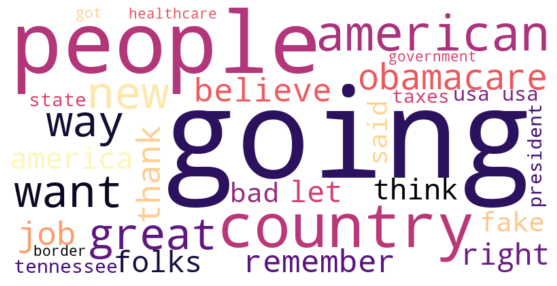

In [18]:
wordcloud = WordCloud(max_words=30, background_color='white',colormap='magma',width=800, height=400, random_state=48).generate(df.loc[100,'Transcript'])
plt.figure(figsize=[10,5])
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.savefig('wordcloud1.png',transparent=True, bbox_inches='tight')

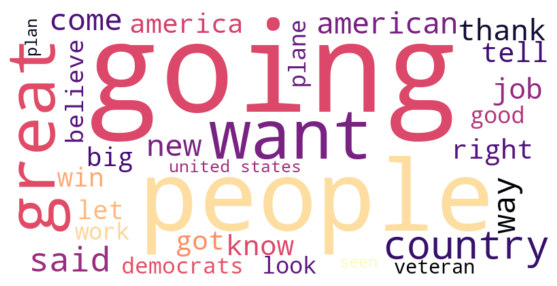

In [19]:
wordcloud = WordCloud(max_words=30, background_color='white',colormap='magma',width=800, height=400, random_state=71).generate(df.loc[101,'Transcript'])
plt.figure(figsize=[10,5])
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.savefig('wordcloud2.png',transparent=True, bbox_inches='tight')

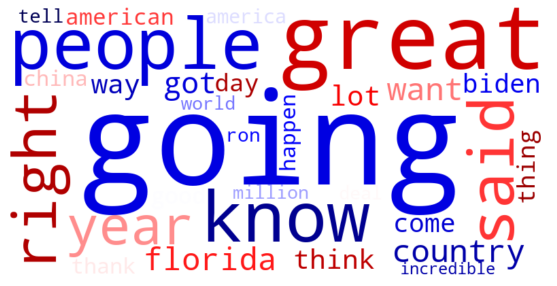

In [20]:
wordcloud = WordCloud(max_words=30,background_color='white',colormap='seismic',width=800, height=400,random_state=28).generate(df.loc[0,'Transcript'])
plt.figure(figsize=[10,5])
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.savefig('wordcloud3.png',transparent=True, bbox_inches='tight')

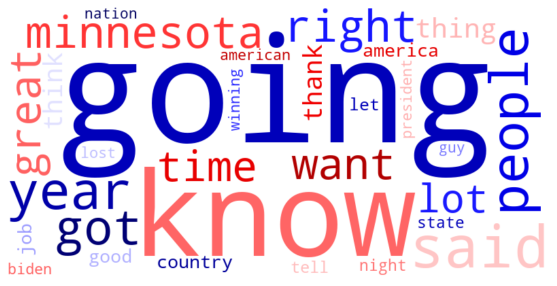

In [21]:
wordcloud = WordCloud(max_words=30, background_color='white',colormap='seismic',width=800, height=400,random_state=48).generate(df.loc[1,'Transcript'])
plt.figure(figsize=[10,5])
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.savefig('wordcloud4.png',transparent=True, bbox_inches='tight')

## Topic Modeling and Exploratory Data Analysis with Heatmap
- Scikit-learn Count Vectorizer
- Scikit-learn Non-negative Matrix Factorization (NMF)
- Scikit-learn Cosine Similarity

In [22]:
count_vectorizer = CountVectorizer(stop_words = 'english')
doc_term = count_vectorizer.fit_transform(list(df['Transcript']))
countvec = count_vectorizer.fit(list(df['Transcript']))
dt_matrix = pd.DataFrame(doc_term.toarray().round(3), index=[i for i in df['Place']], columns=count_vectorizer.get_feature_names()).head(10)
dt_matrix 

aand  abandon  abandoned  abandoning  \
Rally in Sanford, Florida                 0        0          0           0   
Rally in Duluth, Minnesota                0        0          0           0   
Rally in Middletown, Pennsylvania         1        0          0           0   
Rally in Newport News, Virginia           0        0          0           0   
Rally in Jacksonville, Florida            0        0          0           0   
Rally in Moon Township, Pennsylvania      0        0          0           0   
Rally in Swanton, Ohio                    0        0          0           0   
Rally in Fayetteville, North Carolina     0        0          0           0   
Rally in Bedmidji, Minnesota              0        0          0           0   
Rally in Mosinee, Wisconsin               0        0          0           0   

                                       abbey  abbott  abby  abc  abducted  \
Rally in Sanford, Florida                  0       0     0    0         0   
Rally in Duluth, Minnesota                 0       0     0    0         0   
Rally in Middletown, Pennsylvania          0       0     0    0         0   
Rally in Newport News, Virginia            0       0     0    2         0   
Rally in Jacksonville, Florida             0       0     0    0         0   
Rally in Moon Township, Pennsylvania       0       2     0    0         0   
Rally in Swanton, Ohio                     0       0     0    0         0   
Rally in Fayetteville, North Carolina      0       0     0    0         0   
Rally in Bedmidji, Minnesota               0       1     0    2         0   
Rally in Mosinee, Wisconsin                0       0     0    0         0   

                                       abe  abetting  abide  abiding  ability  \
Rally in Sanford, Florida                0         0      0        0        0   
Rally in Duluth, Minnesota               0         0      0        0        0   
Rally in Middletown, Pennsylvania        0         0      0        0        0   
Rally in Newport News, Virginia          1         0      0        1        1   
Rally in Jacksonville, Florida           0         0      0        0        0   
Rally in Moon Township, Pennsylvania     0         0      0        0        0   
Rally in Swanton, Ohio                   0         0      0        0        0   
Rally in Fayetteville, North Carolina    1         0      0        0        0   
Rally in Bedmidji, Minnesota             0         0      0        0        0   
Rally in Mosinee, Wisconsin              1         0      0        0        1   

                                       able  aboard  abolish  abolished  \
Rally in Sanford, Florida                 1       0        0          0   
Rally in Duluth, Minnesota                2       0        0          0   
Rally in Middletown, Pennsylvania         0       0        0          0   
Rally in Newport News, Virginia           1       0        0          0   
Rally in Jacksonville, Florida            0       0        0          0   
Rally in Moon Township, Pennsylvania      5       0        2          0   
Rally in Swanton, Ohio                    8       0        0          0   
Rally in Fayetteville, North Carolina     3       0        0          0   
Rally in Bedmidji, Minnesota              3       0        0          0   
Rally in Mosinee, Wisconsin               2       0        1          0   

                                       abolishes  abolishing  abortion  \
Rally in Sanford, Florida                      0           0         0   
Rally in Duluth, Minnesota                     0           1         0   
Rally in Middletown, Pennsylvania              0           0         1   
Rally in Newport News, Virginia                0           0         0   
Rally in Jacksonville, Florida                 0           1         1   
Rally in Moon Township, Pennsylvania           0           0         0   
Rally in Swanton, Ohio                         0           0         1   
Rally in Fa

### Try NMF with Countvectorizer (Random = 42)

In [23]:
nmf_model = NMF(n_components = 3,random_state=42)
model = nmf_model.fit(doc_term)
doc_topic = model.transform(doc_term)

In [24]:
topic_word = pd.DataFrame(nmf_model.components_.round(3),
             index = ["component_1","component_2","component_3"],
             columns = count_vectorizer.get_feature_names())
topic_word

aand  abandon  abandoned  abandoning  abbey  abbott   abby  \
component_1  0.001     0.00       0.00       0.000  0.002   0.011  0.003   
component_2  0.000     0.01       0.03       0.008  0.001   0.000  0.005   
component_3  0.011     0.00       0.00       0.000  0.001   0.023  0.000   

               abc  abducted    abe  abetting  abide  abiding  ability   able  \
component_1  0.077     0.009  0.120     0.008  0.000    0.018    0.020  0.433   
component_2  0.000     0.000  0.067     0.000  0.005    0.155    0.011  0.265   
component_3  0.026     0.000  0.011     0.000  0.000    0.006    0.020  0.184   

             aboard  abolish  abolished  abolishes  abolishing  abortion  \
component_1   0.000    0.000      0.000      0.000       0.000     0.297   
component_2   0.003    0.217      0.008      0.005       0.000     0.130   
component_3   0.000    0.057      0.000      0.000       0.033     0.000   

             abortions  abraham  abrams  abroad  absentee  absolute  \
component_1      0.004    0.243   0.011   0.000     0.000     0.068   
component_2      0.004    0.000   0.053   0.023     0.000     0.040   
component_3      0.000    0.094   0.000   0.005     0.033     0.028   

             absolutely  abstract  abuse  abused  abuses  abusing  abusive  \
component_1       0.141     0.000  0.053   0.000   0.006    0.000    0.000   
component_2       0.102     0.003  0.036   0.007   0.043    0.001    0.081   
component_3       0.057     0.000  0.044   0.000   0.000    0.006    0.000   

             academic  academically  academics  academies  academy  \
component_1     0.000         0.000      0.004      0.018    0.134   
component_2     0.004         0.000      0.001      0.000    0.054   
component_3     0.000         0.009      0.000      0.000    0.000   

             accelerating  accent  accept  acceptable  accepted  accepting  \
component_1         0.001   0.006   0.036       0.006     0.000      0.023   
component_2         0.003   0.011   0.019       0.011     0.006      0.001   
component_3         0.000   0.007   0.029       0.046     0.035      0.000   

             accepts  access  accessible  accident  accidentally  acclaim  \
component_1    0.005   0.000       0.001     0.008         0.000    0.000   
component_2    0.000   0.092       0.002     0.003         0.003    0.003   
component_3    0.000   0.011       0.000     0.017         0.009    0.001   

             accommodate  accomplish  accomplished  accomplishing  \
component_1        0.000       0.000         0.063          0.000   
component_2        0.004       0.016         0.032          0.013   
component_3        0.000       0.002         0.000          0.000   

             accomplishments  accord  according  account  accountability  \
component_1            0.000   0.002      0.003    0.006           0.061   
component_2            0.002   0.081      0.049    0.002           0.331   
component_3            0.002   0.058      0.019    0.000           0.059   

             accountable  accounts  accumulated  accurate  accurately  \
component_1        0.000     0.001        0.002     0.036       0.000   
component_2        0.123     0.002        0.000     0.000       0.001   
component_3        0.000     0.000        0.004     0.038       0.002   

             accusation  accusations  accuse  accused  accuser  accusers  \
component_1       0.000        0.000   0.000    0.031    0.000     0.000   
component_2       0.008        0.042   0.006    0.000    0.012     0.011   
component_3       0.000        0.000   0.000    0.065    0.000     0.000   

             accusing  achieve  achieved  achievement  achievements  achieves  \
component_1     0.027    0.089     0.000        0.042         0.000     0.005   
component_2     0.000    0.063     0.137        0.001         0.042     0.000   
component_3     0.000    0.000     0.287        0.016         0.000     0.000   

             achieving   acid  acknowledge  acknowledged  acosta  acquitt

In [25]:
def display_topics(model, feature_names, no_top_words, topic_names=None):
    for ix, topic in enumerate(model.components_):
        if not topic_names or not topic_names[ix]:
            print("\nTopic ", ix)
        else:
            print("\nTopic: '",topic_names[ix],"'")
        print(", ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))

In [26]:
display_topics(nmf_model, count_vectorizer.get_feature_names(), 30)


Topic  0
know, said, right, people, like, great, got, think, going, want, good, lot, years, president, guy, time, thing, look, won, sir, trump, love, way, big, billion, remember, come, let, money, million

Topic  1
going, great, want, people, country, thank, vote, know, america, american, right, like, years, president, got, democrats, way, good, jobs, time, lot, need, think, said, come, new, state, job, let, love

Topic  2
going, know, said, people, got, biden, great, like, right, want, think, years, joe, good, way, thank, china, remember, america, lot, country, let, thing, look, tell, win, guy, time, job, big


In [27]:
topic_index = []
feature_names = count_vectorizer.get_feature_names()
for ix, topic in enumerate(nmf_model.components_):
    topic_index.append(" ".join([feature_names[i] for i in topic.argsort()]))

In [28]:
H = pd.DataFrame(doc_topic.round(3),
             index = [i for i in df['Place']],
             columns = ["component_1","component_2","component_3"])
H

component_1  component_2  \
Rally in Sanford, Florida                        0.376        2.349   
Rally in Duluth, Minnesota                       0.060        0.895   
Rally in Middletown, Pennsylvania                2.058        0.647   
Rally in Newport News, Virginia                  2.830        0.310   
Rally in Jacksonville, Florida                   1.708        1.403   
Rally in Moon Township, Pennsylvania             3.171        1.535   
Rally in Swanton, Ohio                           1.398        1.452   
Rally in Fayetteville, North Carolina            6.343        0.501   
Rally in Bedmidji, Minnesota                     7.949        0.000   
Rally in Mosinee, Wisconsin                      3.718        0.762   
Rally in Henderson, Nevada                       0.569        1.598   
Rally in Minden, Nevada                          1.898        0.766   
Rally in Freeland, Michigan                      1.935        0.231   
Rally in Winston-Salem, North Carolina           0.431        1.773   
Rally in Tulsa, Oklahoma                         3.201        2.587   
Rally in Charlotte, North Carolina               2.283        2.127   
Rally in North Charleston, South Carolina        3.417        3.227   
Rally in Las Vegas, Nevada                       7.975        1.817   
Rally in Colorado Springs, Colorado              7.589        2.606   
Rally in Phoenix, Arizona                        3.431        3.466   
Rally in Manchester, New Hampshire               1.252        3.345   
Rally in Des Moines, Iowa                        4.418        3.411   
Rally in Wildwood, New Jersey                    1.176        3.706   
Rally in Milwaukee, Wisconsin                    3.777        2.499   
Rally in Toledo, Ohio                            4.412        2.950   
Rally in Battle Creek, Michigan                 10.048        2.370   
Rally in Hershey, Pennsylvania                   3.136        2.622   
Rally in Sunrise, Florida                        3.233        3.468   
Rally in Bossier City, Louisiana                 1.044        3.515   
Rally in Monroe, Louisiana                       1.648        3.633   
Rally in Lexington, Kentucky                     1.893        3.520   
Rally in Tupelo, Mississippi                     4.362        2.619   
Rally in Dallas, Texas                           4.143        2.795   
Rally in Minneapolis, Minnesota                  3.997        2.421   
Rally in Lake Charles, Louisiana                 3.727        3.208   
Rally in Rio Rancho, New Mexico                  3.549        4.250   
Rally in Fayetteville, North Carolina            1.931        4.786   
Rally in Manchester, New Hampshire               2.766        3.877   
Rally in Cincinnati, Ohio                        2.624        2.926   
Rally in Greenville, North Carolina              3.492        3.757   
Rally in Orlando                                 0.371        4.387   
Rally in Montoursville, Pennsylvania             0.855        3.691   
Rally in Panama City Beach, Florida              3.135        4.638   
Rally in Green Bay, Wisconsin                    2.481        3.458   
Rally in Grand Rapids, Michigan                  2.856        3.412   
Rally in El Paso, Texas                          1.556        3.551   
Rally in Tupelo, Mississippi                     1.191        3.243   
Rally in Biloxi, Mississippi                     0.306        2.835   
Rally in Fort Wayne, Indiana                     1.075        4.022   
Rally in Cape Girardeau, Missouri                2.236        3.669   
Rally in Cleveland, Ohio                         1.015        3.132   
Rally in Macon, Georgia                          1.254        3.895   
Rally in Chattanooga, Tennessee                  0.373        3.234   
Rally in Pensacola, Florida                      1.101        4.823   
Rally in Belgrade, Montana                       1.869        3.965   
Rally in Indianapolis, Indiana                   1.457        3.404

In [29]:
H = H.reset_index()
H = df.join(H).drop(['Transcript','index'],axis=1)
H

Place       Date  component_1  \
0                    Rally in Sanford, Florida 2020-10-12        0.376   
1                   Rally in Duluth, Minnesota 2020-09-30        0.060   
2            Rally in Middletown, Pennsylvania 2020-09-26        2.058   
3              Rally in Newport News, Virginia 2020-09-25        2.830   
4               Rally in Jacksonville, Florida 2020-09-24        1.708   
5         Rally in Moon Township, Pennsylvania 2020-09-22        3.171   
6                       Rally in Swanton, Ohio 2020-09-21        1.398   
7        Rally in Fayetteville, North Carolina 2020-09-19        6.343   
8                 Rally in Bedmidji, Minnesota 2020-09-18        7.949   
9                  Rally in Mosinee, Wisconsin 2020-09-17        3.718   
10                  Rally in Henderson, Nevada 2020-09-13        0.569   
11                     Rally in Minden, Nevada 2020-09-12        1.898   
12                 Rally in Freeland, Michigan 2020-09-10        1.935   
13      Rally in Winston-Salem, North Carolina 2020-09-08        0.431   
14                    Rally in Tulsa, Oklahoma 2020-06-20        3.201   
15          Rally in Charlotte, North Carolina 2020-03-02        2.283   
16   Rally in North Charleston, South Carolina 2020-02-28        3.417   
17                  Rally in Las Vegas, Nevada 2020-02-21        7.975   
18         Rally in Colorado Springs, Colorado 2020-02-20        7.589   
19                   Rally in Phoenix, Arizona 2020-02-19        3.431   
20          Rally in Manchester, New Hampshire 2020-02-10        1.252   
21                   Rally in Des Moines, Iowa 2020-01-30        4.418   
22               Rally in Wildwood, New Jersey 2020-01-28        1.176   
23               Rally in Milwaukee, Wisconsin 2020-01-14        3.777   
24                       Rally in Toledo, Ohio 2020-01-09        4.412   
25             Rally in Battle Creek, Michigan 2019-12-18       10.048   
26              Rally in Hershey, Pennsylvania 2019-12-10        3.136   
27                   Rally in Sunrise, Florida 2019-11-26        3.233   
28            Rally in Bossier City, Louisiana 2019-11-14        1.044   
29                  Rally in Monroe, Louisiana 2019-11-06        1.648   
30                Rally in Lexington, Kentucky 2019-11-04        1.893   
31                Rally in Tupelo, Mississippi 2019-11-01        4.362   
32                      Rally in Dallas, Texas 2019-10-17        4.143   
33             Rally in Minneapolis, Minnesota 2019-10-10        3.997   
34            Rally in Lake Charles, Louisiana 2019-10-10        3.727   
35             Rally in Rio Rancho, New Mexico 2019-09-16        3.549   
36       Rally in Fayetteville, North Carolina 2019-09-09        1.931   
37          Rally in Manchester, New Hampshire 2019-08-15        2.766   
38                   Rally in Cincinnati, Ohio 2019-08-01        2.624   
39         Rally in Greenville, North Carolina 2019-07-17        3.492   
40                            Rally in Orlando 2019-06-18        0.371   
41        Rally in Montoursville, Pennsylvania 2019-05-20        0.855   
42         Rally in Panama City Beach, Florida 2019-05-08        3.135   
43               Rally in Green Bay, Wisconsin 2019-04-27        2.481   
44             Rally in Grand Rapids, Michigan 2019-03-28        2.856   
45                     Rally in El Paso, Texas 2019-02-11        1.556   
46                Rally in Tupelo, Mississippi 2018-11-26        1.191   
47                Rally in Biloxi, Mississippi 2018-11-26        0.306   
48                Rally in Fort Wayne, Indiana 2018-11-05        1.075   
49           Rally in Cape Girardeau, Missouri 2018-11-05        2.236   
50                    Rally in Cleveland, Ohio 2018-11-05        1.015   
51                     Rally in Macon, Georgia 2018-11-04        1.254   
52             Rally in Chattanooga, Tennessee 2018-11-04        0.373   
53                 Rally in Pensacola, Florid

In [30]:
H = H.rename(columns={'component_1':'Achievements','component_2':'Plans and Appealing Support','component_3':'Political Adversaries'})
H

Place       Date  Achievements  \
0                    Rally in Sanford, Florida 2020-10-12         0.376   
1                   Rally in Duluth, Minnesota 2020-09-30         0.060   
2            Rally in Middletown, Pennsylvania 2020-09-26         2.058   
3              Rally in Newport News, Virginia 2020-09-25         2.830   
4               Rally in Jacksonville, Florida 2020-09-24         1.708   
5         Rally in Moon Township, Pennsylvania 2020-09-22         3.171   
6                       Rally in Swanton, Ohio 2020-09-21         1.398   
7        Rally in Fayetteville, North Carolina 2020-09-19         6.343   
8                 Rally in Bedmidji, Minnesota 2020-09-18         7.949   
9                  Rally in Mosinee, Wisconsin 2020-09-17         3.718   
10                  Rally in Henderson, Nevada 2020-09-13         0.569   
11                     Rally in Minden, Nevada 2020-09-12         1.898   
12                 Rally in Freeland, Michigan 2020-09-10         1.935   
13      Rally in Winston-Salem, North Carolina 2020-09-08         0.431   
14                    Rally in Tulsa, Oklahoma 2020-06-20         3.201   
15          Rally in Charlotte, North Carolina 2020-03-02         2.283   
16   Rally in North Charleston, South Carolina 2020-02-28         3.417   
17                  Rally in Las Vegas, Nevada 2020-02-21         7.975   
18         Rally in Colorado Springs, Colorado 2020-02-20         7.589   
19                   Rally in Phoenix, Arizona 2020-02-19         3.431   
20          Rally in Manchester, New Hampshire 2020-02-10         1.252   
21                   Rally in Des Moines, Iowa 2020-01-30         4.418   
22               Rally in Wildwood, New Jersey 2020-01-28         1.176   
23               Rally in Milwaukee, Wisconsin 2020-01-14         3.777   
24                       Rally in Toledo, Ohio 2020-01-09         4.412   
25             Rally in Battle Creek, Michigan 2019-12-18        10.048   
26              Rally in Hershey, Pennsylvania 2019-12-10         3.136   
27                   Rally in Sunrise, Florida 2019-11-26         3.233   
28            Rally in Bossier City, Louisiana 2019-11-14         1.044   
29                  Rally in Monroe, Louisiana 2019-11-06         1.648   
30                Rally in Lexington, Kentucky 2019-11-04         1.893   
31                Rally in Tupelo, Mississippi 2019-11-01         4.362   
32                      Rally in Dallas, Texas 2019-10-17         4.143   
33             Rally in Minneapolis, Minnesota 2019-10-10         3.997   
34            Rally in Lake Charles, Louisiana 2019-10-10         3.727   
35             Rally in Rio Rancho, New Mexico 2019-09-16         3.549   
36       Rally in Fayetteville, North Carolina 2019-09-09         1.931   
37          Rally in Manchester, New Hampshire 2019-08-15         2.766   
38                   Rally in Cincinnati, Ohio 2019-08-01         2.624   
39         Rally in Greenville, North Carolina 2019-07-17         3.492   
40                            Rally in Orlando 2019-06-18         0.371   
41        Rally in Montoursville, Pennsylvania 2019-05-20         0.855   
42         Rally in Panama City Beach, Florida 2019-05-08         3.135   
43               Rally in Green Bay, Wisconsin 2019-04-27         2.481   
44             Rally in Grand Rapids, Michigan 2019-03-28         2.856   
45                     Rally in El Paso, Texas 2019-02-11         1.556   
46                Rally in Tupelo, Mississippi 2018-11-26         1.191   
47                Rally in Biloxi, Mississippi 2018-11-26         0.306   
48                Rally in Fort Wayne, Indiana 2018-11-05         1.075   
49           Rally in Cape Girardeau, Missouri 2018-11-05         2.236   
50                    Rally in Cleveland, Ohio 2018-11-05         1.015   
51                     Rally in Macon, Georgia 2018-11-04         1.254   
52             Rally in Chattanooga, Tennessee 2018-11-04         

In [31]:
DF = H.copy()
DF = DF.drop(['Place','Date'],axis=1)
DF = DF.iloc[:21]
cos_similar_matrix = pd.DataFrame(cosine_similarity(DF.values),columns=H['Date'].iloc[:21].astype(str),index=H['Date'].iloc[:21].astype(str))
cos_similar_matrix

Date        2020-10-12  2020-09-30  2020-09-26  2020-09-25  2020-09-24  \
Date                                                                     
2020-10-12    1.000000    0.959464    0.918977    0.877037    0.947126   
2020-09-30    0.959464    1.000000    0.957043    0.920720    0.918730   
2020-09-26    0.918977    0.957043    1.000000    0.994060    0.972325   
2020-09-25    0.877037    0.920720    0.994060    1.000000    0.964869   
2020-09-24    0.947126    0.918730    0.972325    0.964869    1.000000   
2020-09-22    0.918857    0.919549    0.987925    0.988216    0.993332   
2020-09-21    0.966841    0.980343    0.988907    0.968289    0.977827   
2020-09-19    0.728987    0.736831    0.900085    0.938265    0.909302   
2020-09-18    0.635399    0.645778    0.838957    0.889959    0.849179   
2020-09-17    0.873814    0.898486    0.986704    0.996563    0.974538   
2020-09-13    0.987541    0.988411    0.963950    0.930611    0.959874   
2020-09-12    0.929788    0.982154    0.992827    0.976480    0.950231   
2020-09-10    0.901429    0.957447    0.997944    0.992808    0.955369   
2020-09-08    0.974995    0.997587    0.963156    0.928166    0.940344   
2020-06-20    0.835071    0.731069    0.843135    0.853534    0.938541   
2020-03-02    0.700907    0.537402    0.669151    0.685717    0.815275   
2020-02-28    0.338659    0.114430    0.277521    0.309949    0.476739   
2020-02-21    0.253293    0.147900    0.405422    0.480436    0.517038   
2020-02-20    0.200825    0.060407    0.308428    0.379155    0.447768   
2020-02-19    0.347228    0.117932    0.272826    0.301881    0.475358   
2020-02-10    0.418657    0.149398    0.189836    0.175069    0.413527   

Date        2020-09-22  2020-09-21  2020-09-19  2020-09-18  2020-09-17  \
Date                                                                     
2020-10-12    0.918857    0.966841    0.728987    0.635399    0.873814   
2020-09-30    0.919549    0.980343    0.736831    0.645778    0.898486   
2020-09-26    0.987925    0.988907    0.900085    0.838957    0.986704   
2020-09-25    0.988216    0.968289    0.938265    0.889959    0.996563   
2020-09-24    0.993332    0.977827    0.909302    0.849179    0.974538   
2020-09-22    1.000000    0.978081    0.936785    0.883543    0.993711   
2020-09-21    0.978081    1.000000    0.846443    0.770765    0.960728   
2020-09-19    0.936785    0.846443    1.000000    0.991568    0.958768   
2020-09-18    0.883543    0.770765    0.991568    1.000000    0.915333   
2020-09-17    0.993711    0.960728    0.958768    0.915333    1.000000   
2020-09-13    0.949510    0.992512    0.780015    0.692415    0.920458   
2020-09-12    0.965133    0.990487    0.842911    0.770897    0.960450   
2020-09-10    0.977122    0.982011    0.890133    0.829667    0.980980   
2020-09-08    0.936114    0.988827    0.759131    0.669460    0.911406   
2020-06-20    0.915780    0.846188    0.905195    0.872270    0.891027   
2020-03-02    0.775415    0.679924    0.802041    0.786079    0.741075   
2020-02-28    0.422884    0.287326    0.532050    0.555146    0.386738   
2020-02-21    0.523578    0.339497    0.748684    0.808007    0.545561   
2020-02-20    0.440291    0.255994    0.661565    0.722186    0.451185   
2020-02-19    0.418148    0.287623    0.517326    0.537185    0.378455   
2020-02-10    0.320895    0.264005    0.289099    0.267665    0.241774   

Date        2020-09-13  2020-09-12  2020-09-10  2020-09-08  2020-06-20  \
Date                                                                     
2020-10-12    0.987541    0.929788    0.901429    0.974995    0.835071   
2020-09-30    0.988411    0.982154    0.957447    0.997587    0.731069   
2020-09-26    0.963950    0.992827    0.997944    0.963156    0.843135   
2020-09-25    0.930611    0.976480    0.992808    0.928166    0.853534   
2020-09-24    0.959874    0.950231    0.955369    0.940344    0.938541   
2020-09-22    0.949510    0.965133    0.977122    0.936114    0.915780   
20

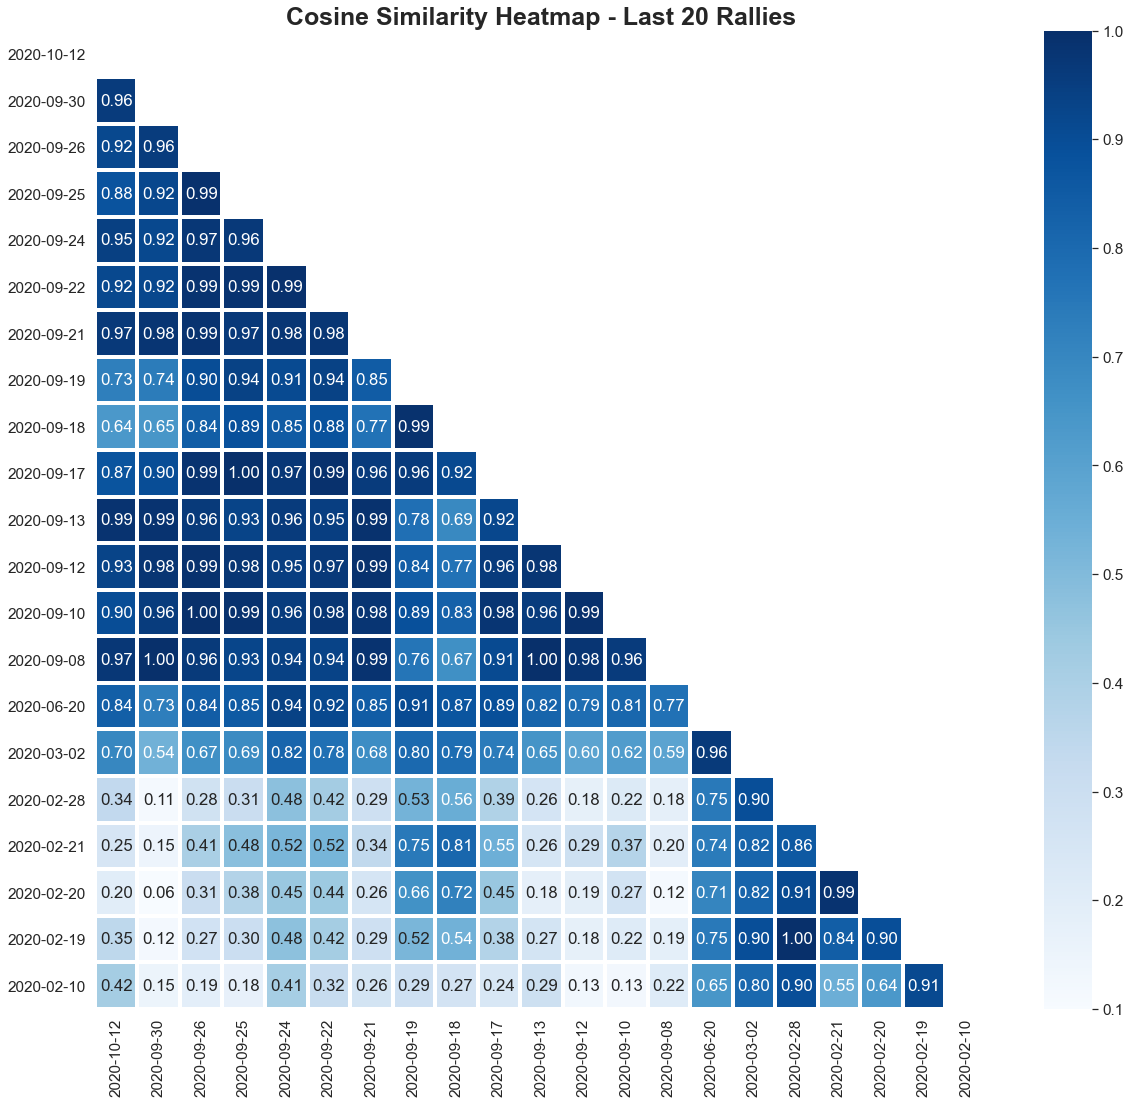

In [32]:
sns.set(style='white',font_scale=1.4)
fig = plt.figure(figsize=[20,18])
mask = np.triu(np.ones_like(cos_similar_matrix, dtype=bool))
sns.heatmap(cos_similar_matrix,cmap='Blues',linewidth=3,linecolor='white',vmax = 1, vmin=0.1,mask=mask, annot=True,fmt='0.2f')
plt.title('Cosine Similarity Heatmap - Last 20 Rallies', weight='bold',fontsize=25)
plt.xlabel('')
plt.ylabel('')
plt.savefig('heatmap.png',transparent=True, bbox_inches='tight')

## Time Series with SARIMA
- Create Simple Validation manually
- Observe seasonality in topics in Trump rallies
- Time Series is observed to be non-stationary with trend and seasonality => SARIMA
- Manually optimize the period and trend parameter in SARIMA
- MAE is used as a metric for prediction

In [33]:
data = H.drop(['Place','Date'],axis=1)
data.index = H['Date']
data

Achievements  Plans and Appealing Support  Political Adversaries
Date                                                                        
2020-10-12         0.376                        2.349                  5.036
2020-09-30         0.060                        0.895                  5.681
2020-09-26         2.058                        0.647                  6.651
2020-09-25         2.830                        0.310                  6.749
2020-09-24         1.708                        1.403                  4.063
2020-09-22         3.171                        1.535                  7.120
2020-09-21         1.398                        1.452                  6.711
2020-09-19         6.343                        0.501                  6.802
2020-09-18         7.949                        0.000                  6.722
2020-09-17         3.718                        0.762                  7.429
2020-09-13         0.569                        1.598                  5.538
2020-09-12         1.898                        0.766                 10.342
2020-09-10         1.935                        0.231                  6.797
2020-09-08         0.431                        1.773                  8.216
2020-06-20         3.201                        2.587                  3.611
2020-03-02         2.283                        2.127                  1.532
2020-02-28         3.417                        3.227                  0.000
2020-02-21         7.975                        1.817                  0.861
2020-02-20         7.589                        2.606                  0.000
2020-02-19         3.431                        3.466                  0.000
2020-02-10         1.252                        3.345                  0.000
2020-01-30         4.418                        3.411                  0.968
2020-01-28         1.176                        3.706                  0.000
2020-01-14         3.777                        2.499                  1.112
2020-01-09         4.412                        2.950                  1.719
2019-12-18        10.048                        2.370                  0.597
2019-12-10         3.136                        2.622                  0.759
2019-11-26         3.233                        3.468                  0.592
2019-11-14         1.044                        3.515                  0.803
2019-11-06         1.648                        3.633                  1.038
2019-11-04         1.893                        3.520                  1.171
2019-11-01         4.362                        2.619                  0.059
2019-10-17         4.143                        2.795                  1.282
2019-10-10         3.997                        2.421                  2.104
2019-10-10         3.727                        3.208                  0.761
2019-09-16         3.549                        4.250                  0.000
2019-09-09         1.931                        4.786                  0.275
2019-08-15         2.766                        3.877                  0.000
2019-08-01         2.624                        2.926                  0.000
2019-07-17         3.492                        3.757                  1.121
2019-06-18         0.371                        4.387                  0.422
2019-05-20         0.855                        3.691                  1.490
2019-05-08         3.135                        4.638                  0.227
2019-04-27         2.481                        3.458                  1.190
2019-03-28         2.856                        3.412                  0.000
2019-02-11         1.556                        3.551                  0.691
2018-11-26         1.191                        3.243                  0.000
2018-11-26         0.306                        2.835                  0.000
2018-11-05         1.075                        4.022                  0.000
2018-11-05         2.236                        3.669                  0.000
2018-11-

In [34]:
data = data.iloc[::-1]
data

Achievements  Plans and Appealing Support  Political Adversaries
Date                                                                        
2017-02-18         0.000                        2.822                  1.273
2017-03-15         0.000                        1.908                  0.792
2017-03-20         0.000                        1.862                  2.039
2017-04-29         0.000                        2.661                  0.371
2017-06-21         1.305                        2.849                  2.130
2017-07-25         0.729                        2.603                  0.000
2017-08-03         0.000                        1.989                  0.000
2017-08-22         2.144                        2.839                  0.491
2017-09-22         1.376                        3.259                  5.264
2017-12-08         2.038                        3.354                  1.185
2018-03-10         6.517                        1.853                  0.000
2018-04-28         3.135                        3.167                  2.246
2018-05-10         1.315                        1.972                  1.649
2018-05-29         2.028                        2.890                  0.944
2018-06-20         0.632                        3.149                  1.172
2018-06-23         1.516                        2.671                  0.042
2018-06-25         3.503                        1.753                  1.531
2018-06-27         2.369                        3.309                  0.617
2018-07-05         3.402                        3.096                  0.266
2018-07-31         1.791                        3.235                  0.000
2018-08-02         3.808                        3.072                  0.287
2018-08-04         2.262                        3.646                  1.355
2018-08-21         1.558                        3.648                  1.942
2018-08-30         1.597                        3.739                  0.904
2018-09-06         1.357                        3.689                  2.434
2018-09-20         0.060                        3.292                  1.755
2018-09-21         2.330                        3.030                  0.751
2018-09-29         1.678                        4.283                  0.927
2018-10-01         1.419                        4.271                  0.000
2018-10-02         2.574                        3.245                  0.792
2018-10-04         2.578                        3.931                  0.000
2018-10-06         2.074                        3.173                  0.000
2018-10-09         2.792                        4.183                  0.000
2018-10-10         1.514                        2.929                  1.558
2018-10-12         1.638                        3.556                  0.000
2018-10-13         1.233                        3.499                  0.000
2018-10-18         3.300                        3.178                  0.750
2018-10-19         0.824                        3.800                  0.000
2018-10-20         1.263                        3.865                  0.781
2018-10-22         1.894                        5.233                  0.000
2018-10-24         2.754                        4.732                  0.000
2018-10-26         1.837                        4.034                  0.324
2018-10-27         1.495                        3.933                  1.177
2018-10-31         0.000                        3.613                  0.000
2018-11-01         1.380                        4.612                  0.844
2018-11-02         1.427                        3.456                  0.880
2018-11-02         1.457                        3.404                  0.000
2018-11-03         1.869                        3.965                  0.849
2018-11-03         1.101                        4.823                  0.786
2018-11-04         0.373                        3.234                  0.000
2018-11-

In [35]:
train = data[:int(0.90*(len(data)))]
train

Achievements  Plans and Appealing Support  Political Adversaries
Date                                                                        
2017-02-18         0.000                        2.822                  1.273
2017-03-15         0.000                        1.908                  0.792
2017-03-20         0.000                        1.862                  2.039
2017-04-29         0.000                        2.661                  0.371
2017-06-21         1.305                        2.849                  2.130
2017-07-25         0.729                        2.603                  0.000
2017-08-03         0.000                        1.989                  0.000
2017-08-22         2.144                        2.839                  0.491
2017-09-22         1.376                        3.259                  5.264
2017-12-08         2.038                        3.354                  1.185
2018-03-10         6.517                        1.853                  0.000
2018-04-28         3.135                        3.167                  2.246
2018-05-10         1.315                        1.972                  1.649
2018-05-29         2.028                        2.890                  0.944
2018-06-20         0.632                        3.149                  1.172
2018-06-23         1.516                        2.671                  0.042
2018-06-25         3.503                        1.753                  1.531
2018-06-27         2.369                        3.309                  0.617
2018-07-05         3.402                        3.096                  0.266
2018-07-31         1.791                        3.235                  0.000
2018-08-02         3.808                        3.072                  0.287
2018-08-04         2.262                        3.646                  1.355
2018-08-21         1.558                        3.648                  1.942
2018-08-30         1.597                        3.739                  0.904
2018-09-06         1.357                        3.689                  2.434
2018-09-20         0.060                        3.292                  1.755
2018-09-21         2.330                        3.030                  0.751
2018-09-29         1.678                        4.283                  0.927
2018-10-01         1.419                        4.271                  0.000
2018-10-02         2.574                        3.245                  0.792
2018-10-04         2.578                        3.931                  0.000
2018-10-06         2.074                        3.173                  0.000
2018-10-09         2.792                        4.183                  0.000
2018-10-10         1.514                        2.929                  1.558
2018-10-12         1.638                        3.556                  0.000
2018-10-13         1.233                        3.499                  0.000
2018-10-18         3.300                        3.178                  0.750
2018-10-19         0.824                        3.800                  0.000
2018-10-20         1.263                        3.865                  0.781
2018-10-22         1.894                        5.233                  0.000
2018-10-24         2.754                        4.732                  0.000
2018-10-26         1.837                        4.034                  0.324
2018-10-27         1.495                        3.933                  1.177
2018-10-31         0.000                        3.613                  0.000
2018-11-01         1.380                        4.612                  0.844
2018-11-02         1.427                        3.456                  0.880
2018-11-02         1.457                        3.404                  0.000
2018-11-03         1.869                        3.965                  0.849
2018-11-03         1.101                        4.823                  0.786
2018-11-04         0.373                        3.234                  0.000
2018-11-

In [36]:
valid = data[int(0.90*(len(data))):int(0.95*(len(data)))]
valid

Achievements  Plans and Appealing Support  Political Adversaries
Date                                                                        
2020-09-13         0.569                        1.598                  5.538
2020-09-17         3.718                        0.762                  7.429
2020-09-18         7.949                        0.000                  6.722
2020-09-19         6.343                        0.501                  6.802
2020-09-21         1.398                        1.452                  6.711

In [37]:
test = data[int(0.95*(len(data))):]
test

Achievements  Plans and Appealing Support  Political Adversaries
Date                                                                        
2020-09-22         3.171                        1.535                  7.120
2020-09-24         1.708                        1.403                  4.063
2020-09-25         2.830                        0.310                  6.749
2020-09-26         2.058                        0.647                  6.651
2020-09-30         0.060                        0.895                  5.681
2020-10-12         0.376                        2.349                  5.036

In [38]:
train_Achievements = train['Achievements']
train_Support = train['Plans and Appealing Support']
train_Adversaries = train['Political Adversaries']
valid_Achievements = valid['Achievements']
valid_Support = valid['Plans and Appealing Support']
valid_Adversaries = valid['Political Adversaries']
test_Achievements = test['Achievements']
test_Support = test['Plans and Appealing Support']
test_Adversaries = test['Political Adversaries']

In [39]:
# mae_vector= []

# for period in np.arange(8,13,1):    
#     for trend in ['n','c','t','ct']:
#         for p in [1]:
#             for d in [0]:
#                 for q in [0]:
#                     for P in [1]:
#                         for D in [1]:
#                             for Q in [1]:
#                                 forecast_Adversaries = SARIMAX(train_Adversaries,order=(p,d,q),seasonal_order=(P,D,Q,period),trend=trend).fit().forecast(steps=len(valid_Adversaries))
#                                 MAE_Adversaries = mean_absolute_error(valid['Political Adversaries'],forecast_Adversaries) 
#                                 mae_vector.append((MAE_Adversaries,[(p,d,q),(P,D,Q,period),trend]))
#     print(period)

# mae, para = zip(*mae_vector)        

# print(f'Best Parameters is {para[np.argmin(mae)]}')    
# print(f'Lowest MAE is {min(mae)}') 

In [40]:
# mae_vector= []

# for period in np.arange(8,13,1):    
#     for trend in ['n','c','t','ct']:
#         for p in [1]:
#             for d in [0]:
#                 for q in [0]:
#                     for P in [1]:
#                         for D in [1]:
#                             for Q in [1]:
#                                 forecast_Support = SARIMAX(train_Support,order=(p,d,q),seasonal_order=(P,D,Q,period),trend=trend).fit().forecast(steps=len(valid_Support))
#                                 MAE_Support = mean_absolute_error(valid['Plans and Appealing Support'],forecast_Support) 
#                                 mae_vector.append((MAE_Support,[(p,d,q),(P,D,Q,period),trend]))
#     print(period)

# mae, para = zip(*mae_vector)        

# print(f'Best Parameters is {para[np.argmin(mae)]}')    
# print(f'Lowest MAE is {min(mae)}') 

In [41]:
# mae_vector= []

# for period in np.arange(8,13,1):    
#     for trend in ['n','c','t','ct']:
#         for p in [1]:
#             for d in [0]:
#                 for q in [0]:
#                     for P in [1]:
#                         for D in [1]:
#                             for Q in [1]:
#                                 forecast_Achievements = SARIMAX(train_Achievements,order=(p,d,q),seasonal_order=(P,D,Q,period),trend=trend).fit().forecast(steps=len(valid_Achievements))
#                                 MAE_Achievements = mean_absolute_error(valid['Achievements'],forecast_Achievements) 
#                                 mae_vector.append((MAE_Achievements,[(p,d,q),(P,D,Q,period),trend]))
#     print(period)

# mae, para = zip(*mae_vector)        

# print(f'Best Parameters is {para[np.argmin(mae)]}')    
# print(f'Lowest MAE is {min(mae)}') 

In [42]:
trainvalid = data[:int(0.95*(len(data)))]
trainvalid

Achievements  Plans and Appealing Support  Political Adversaries
Date                                                                        
2017-02-18         0.000                        2.822                  1.273
2017-03-15         0.000                        1.908                  0.792
2017-03-20         0.000                        1.862                  2.039
2017-04-29         0.000                        2.661                  0.371
2017-06-21         1.305                        2.849                  2.130
2017-07-25         0.729                        2.603                  0.000
2017-08-03         0.000                        1.989                  0.000
2017-08-22         2.144                        2.839                  0.491
2017-09-22         1.376                        3.259                  5.264
2017-12-08         2.038                        3.354                  1.185
2018-03-10         6.517                        1.853                  0.000
2018-04-28         3.135                        3.167                  2.246
2018-05-10         1.315                        1.972                  1.649
2018-05-29         2.028                        2.890                  0.944
2018-06-20         0.632                        3.149                  1.172
2018-06-23         1.516                        2.671                  0.042
2018-06-25         3.503                        1.753                  1.531
2018-06-27         2.369                        3.309                  0.617
2018-07-05         3.402                        3.096                  0.266
2018-07-31         1.791                        3.235                  0.000
2018-08-02         3.808                        3.072                  0.287
2018-08-04         2.262                        3.646                  1.355
2018-08-21         1.558                        3.648                  1.942
2018-08-30         1.597                        3.739                  0.904
2018-09-06         1.357                        3.689                  2.434
2018-09-20         0.060                        3.292                  1.755
2018-09-21         2.330                        3.030                  0.751
2018-09-29         1.678                        4.283                  0.927
2018-10-01         1.419                        4.271                  0.000
2018-10-02         2.574                        3.245                  0.792
2018-10-04         2.578                        3.931                  0.000
2018-10-06         2.074                        3.173                  0.000
2018-10-09         2.792                        4.183                  0.000
2018-10-10         1.514                        2.929                  1.558
2018-10-12         1.638                        3.556                  0.000
2018-10-13         1.233                        3.499                  0.000
2018-10-18         3.300                        3.178                  0.750
2018-10-19         0.824                        3.800                  0.000
2018-10-20         1.263                        3.865                  0.781
2018-10-22         1.894                        5.233                  0.000
2018-10-24         2.754                        4.732                  0.000
2018-10-26         1.837                        4.034                  0.324
2018-10-27         1.495                        3.933                  1.177
2018-10-31         0.000                        3.613                  0.000
2018-11-01         1.380                        4.612                  0.844
2018-11-02         1.427                        3.456                  0.880
2018-11-02         1.457                        3.404                  0.000
2018-11-03         1.869                        3.965                  0.849
2018-11-03         1.101                        4.823                  0.786
2018-11-04         0.373                        3.234                  0.000
2018-11-

In [43]:
trainvalid_Achievements = trainvalid['Achievements']
trainvalid_Support = trainvalid['Plans and Appealing Support']
trainvalid_Adversaries = trainvalid['Political Adversaries']

In [44]:
forecast_Adversaries = SARIMAX(trainvalid_Adversaries,order=(1,0,0),seasonal_order=(1,1,1,10),trend='ct').fit().forecast(steps=len(test_Adversaries))
MAE_Adversaries = mean_absolute_error(test['Political Adversaries'],forecast_Adversaries)
print(f'MAE_Adversaries: {MAE_Adversaries}')
    
forecast_Support = SARIMAX(trainvalid_Support,order=(1,0,0),seasonal_order=(1,1,1,8),trend='ct').fit().forecast(steps=len(test_Support))
MAE_Support = mean_absolute_error(test['Plans and Appealing Support'],forecast_Support) 
print(f'MAE_Support: {MAE_Support}')
    
forecast_Achievements = SARIMAX(trainvalid_Achievements,order=(1,0,0),seasonal_order=(1,1,1,9),trend='n').fit().forecast(steps=len(test_Achievements))
MAE_Achievements = mean_absolute_error(test['Achievements'],forecast_Achievements)  
print(f'MAE_Achievements: {MAE_Achievements}')

MAE_Adversaries: 1.0296951369695657
MAE_Support: 0.6194050405301791
MAE_Achievements: 1.30093100281913


In [45]:
predicted = test.copy()
predicted['Achievements'] = list(forecast_Achievements)
predicted['Plans and Appealing Support'] = list(forecast_Support)
predicted['Political Adversaries'] = list(forecast_Adversaries)
predicted

Achievements  Plans and Appealing Support  Political Adversaries
Date                                                                        
2020-09-22      2.479520                     1.380006               6.185478
2020-09-24      1.234076                     0.875410               6.450363
2020-09-25      2.797110                     0.724735               7.136994
2020-09-26      1.592702                     0.750829               6.029907
2020-09-30      1.920620                     0.326505               6.646333
2020-10-12      4.657374                     0.402213               5.917866

In [46]:
test

Achievements  Plans and Appealing Support  Political Adversaries
Date                                                                        
2020-09-22         3.171                        1.535                  7.120
2020-09-24         1.708                        1.403                  4.063
2020-09-25         2.830                        0.310                  6.749
2020-09-26         2.058                        0.647                  6.651
2020-09-30         0.060                        0.895                  5.681
2020-10-12         0.376                        2.349                  5.036

In [47]:
predicted2 = predicted.copy()
predicted2 = predicted2.reset_index()
predicted2['Date'] = predicted2['Date'].astype(str)

In [48]:
H2 = H.copy()
H2['Date'] = H2['Date'].astype(str)

In [49]:
H3 = H2.copy()
H3 = H3.iloc[::-1]

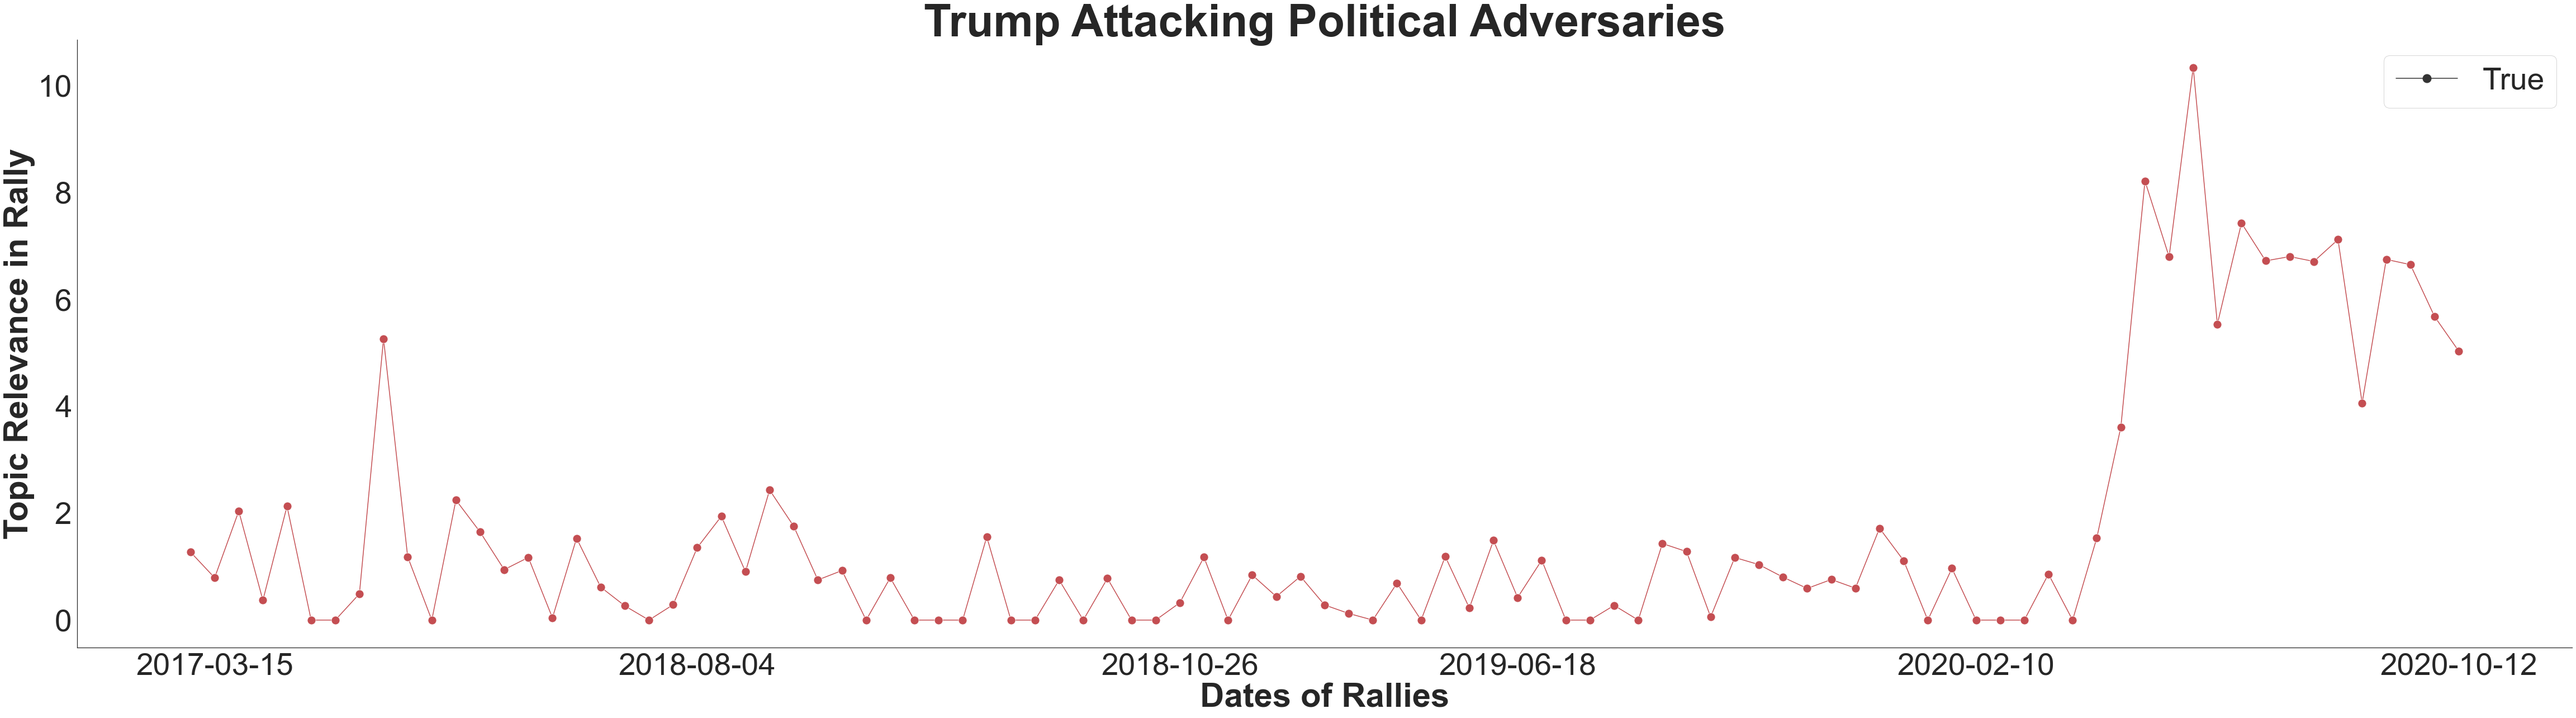

In [50]:
sns.set(style='white',font_scale=5,rc = {'lines.markersize': 15} )
fig = plt.figure(figsize=[80,20])
ax = sns.lineplot(x='Date',y='Political Adversaries',data=H2,style=True,markers=True,ci=None,color='r')
plt.xticks(list(H2['Date'])[0::20])
#ymin, ymax = plt.ylim()
#plt.vlines(list(H2['Date'])[3::10], ymin, ymax, linestyle='dashed')
plt.xlabel('Dates of Rallies',weight='bold',fontsize=60)
plt.ylabel('Topic Relevance in Rally',weight='bold',fontsize=60)
plt.title('Trump Attacking Political Adversaries',weight='bold',fontsize=80)
sns.despine()
plt.savefig('SNSlineplot1_0.png',transparent=True, bbox_inches='tight')

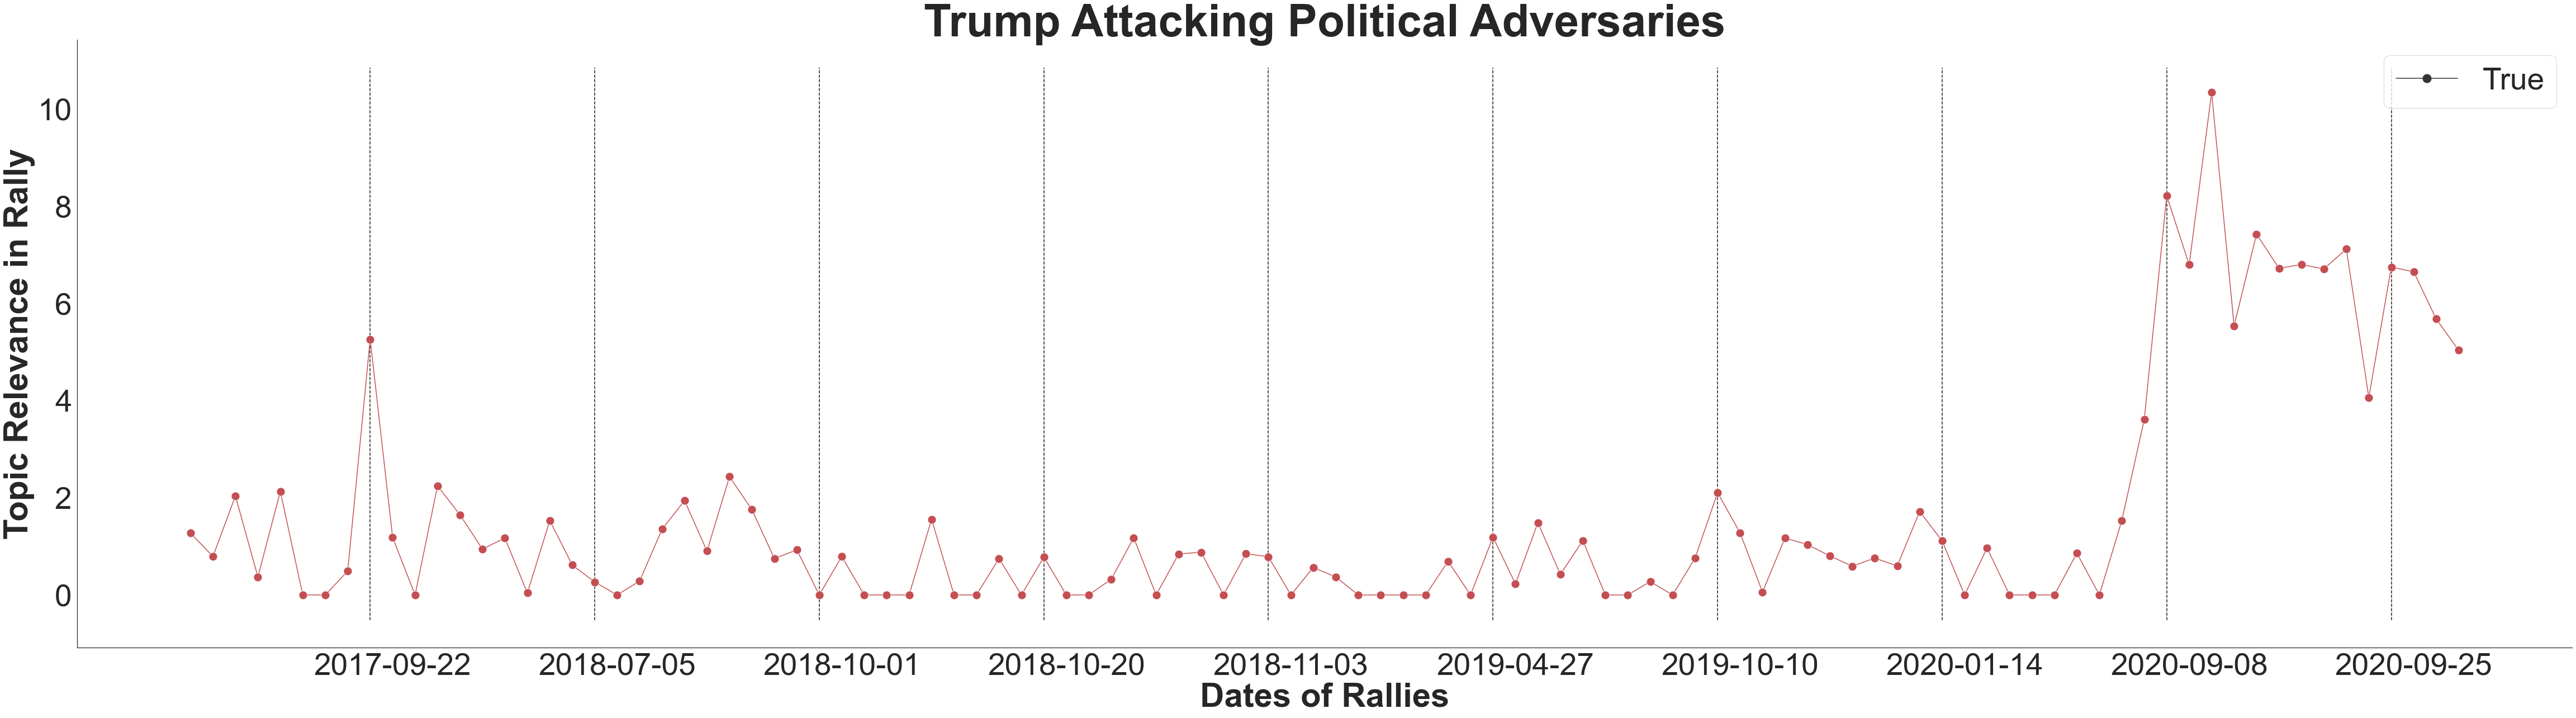

In [51]:
sns.set(style='white',font_scale=5,rc = {'lines.markersize': 15} )
fig = plt.figure(figsize=[80,20])
ax = sns.lineplot(x=H2.index[::-1],y=H2['Political Adversaries'],style=True,markers=True,ci=None,color='r')
lst = ['']*102
lst[-4::-10] = list(H2['Date'][3::10])
plt.xticks(ticks=range(1,103),labels=lst)
ymin, ymax = plt.ylim()
plt.vlines(np.arange(8,103,10), ymin, ymax, linestyle='dashed')
plt.xlabel('Dates of Rallies',weight='bold',fontsize=60)
plt.ylabel('Topic Relevance in Rally',weight='bold',fontsize=60)
plt.title('Trump Attacking Political Adversaries',weight='bold',fontsize=80)
sns.despine()
plt.savefig('SNSlineplot1.png',transparent=True, bbox_inches='tight')

In [52]:
Range = np.arange(8,103,10)

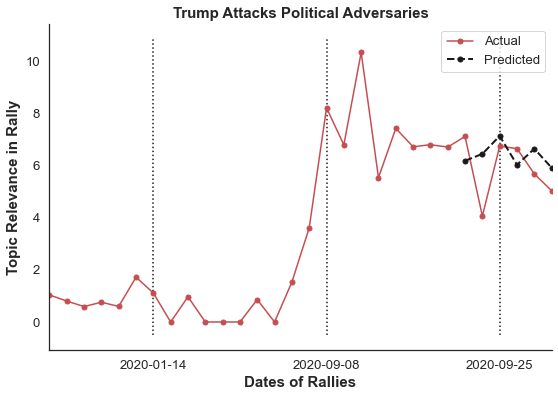

In [53]:
sns.set(style='white',font_scale=1.2,rc = {'lines.markersize': 15} )
fig = plt.figure(figsize=[9,6])
#sns.lineplot(x='Date',y='Political Adversaries',data=H2,style=True,markers=True,ci=None,color='r')
plt.plot(H3['Date'],H3['Political Adversaries'],marker='.',markersize=10,linewidth=1.5,linestyle='-',color='r',label='Actual')
plt.plot(predicted2['Date'],predicted2['Political Adversaries'],marker='.',markersize=10,linewidth=2,linestyle='--',color='k',label='Predicted')
plt.xticks(list(H2['Date'])[3::10])
ymin, ymax = plt.ylim()
plt.vlines(list(H2['Date'])[3::10], ymin, ymax, linestyle=':')
plt.xlim(['2019-11-06','2020-10-12'])
plt.xlabel('Dates of Rallies',weight='bold',fontsize=15)
plt.ylabel('Topic Relevance in Rally',weight='bold',fontsize=15)
plt.title('Trump Attacks Political Adversaries',weight='bold',fontsize=15)
plt.legend()
sns.despine()
plt.savefig('PLTlineplot1.png',transparent=True, bbox_inches='tight')

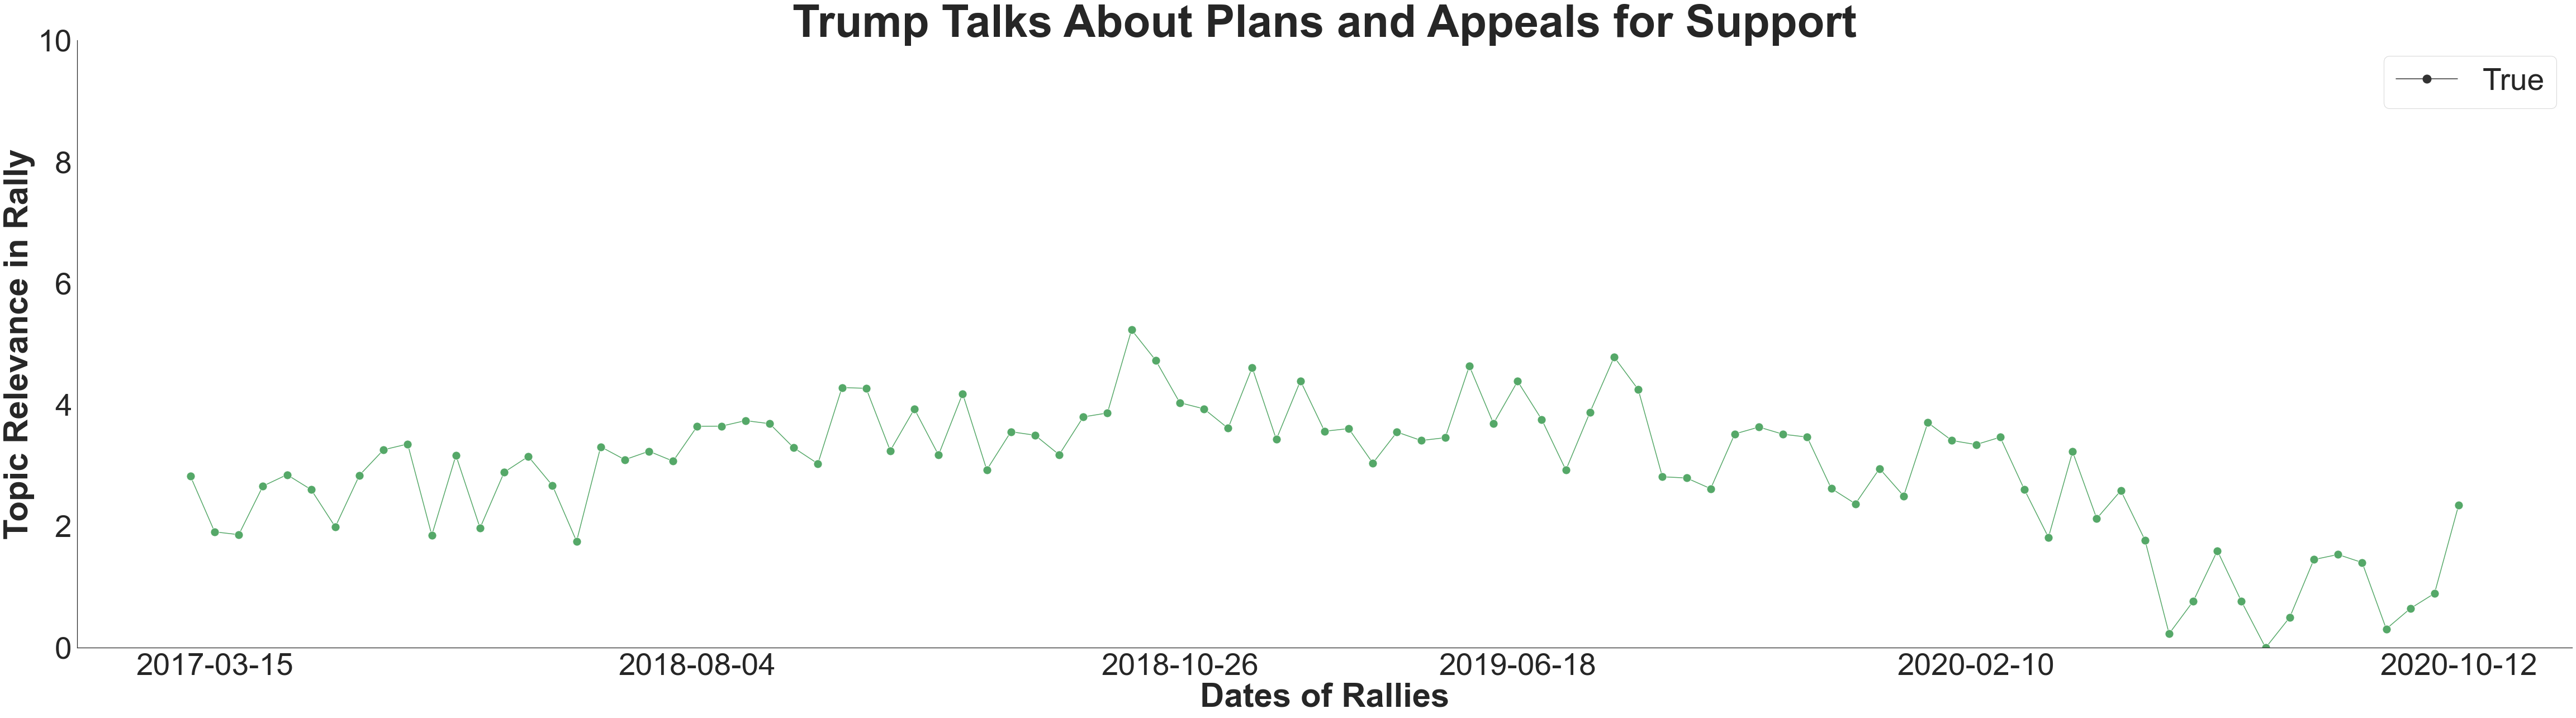

In [54]:
sns.set(style='white',font_scale=5,rc = {'lines.markersize': 15} )
fig = plt.figure(figsize=[80,20])
ax = sns.lineplot(x='Date',y='Plans and Appealing Support',data=H2,style=True,markers=True,ci=None,color='g')
plt.xticks(list(H2['Date'])[0::20])
plt.ylim([0,10])
#ymin, ymax = plt.ylim()
#plt.vlines(list(H2['Date'])[5::8], ymin, ymax, linestyle='dashed')
plt.yticks([0,2,4,6,8,10])
plt.xlabel('Dates of Rallies',weight='bold',fontsize=60)
plt.ylabel('Topic Relevance in Rally',weight='bold',fontsize=60)
plt.title('Trump Talks About Plans and Appeals for Support',weight='bold',fontsize=80)
sns.despine()
plt.savefig('SNSlineplot2_0.png',transparent=True, bbox_inches='tight')

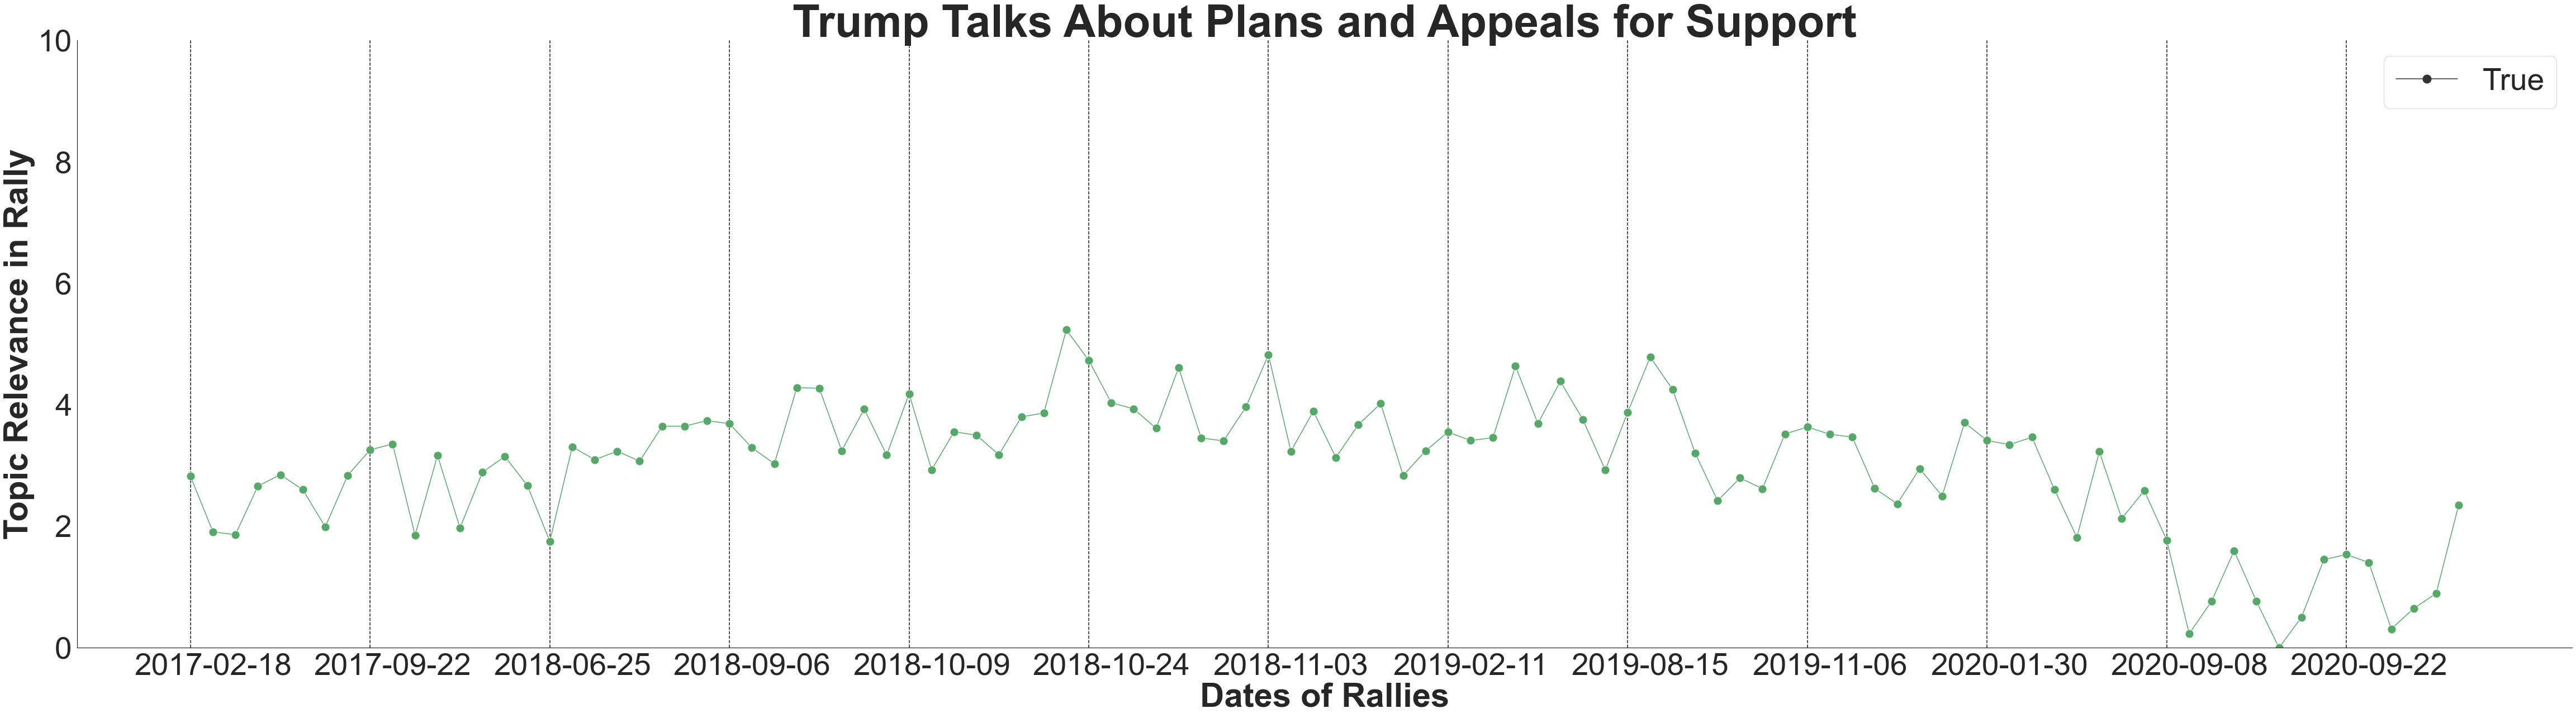

In [55]:
sns.set(style='white',font_scale=5,rc = {'lines.markersize': 15} )
fig = plt.figure(figsize=[80,20])
ax = sns.lineplot(x=H2.index[::-1],y=H2['Plans and Appealing Support'],style=True,markers=True,ci=None,color='g')
lst = ['']*102
lst[-6::-8] = list(H2['Date'][5::8])
plt.xticks(ticks=range(1,103),labels=lst)
plt.ylim([0,10])
ymin, ymax = plt.ylim()
plt.vlines(np.arange(0,103,8), ymin, ymax, linestyle='dashed')
plt.yticks([0,2,4,6,8,10])
plt.xlabel('Dates of Rallies',weight='bold',fontsize=60)
plt.ylabel('Topic Relevance in Rally',weight='bold',fontsize=60)
plt.title('Trump Talks About Plans and Appeals for Support',weight='bold',fontsize=80)
sns.despine()
plt.savefig('SNSlineplot2.png',transparent=True, bbox_inches='tight')

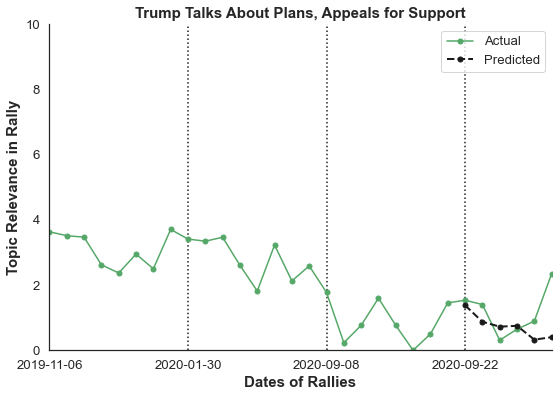

In [56]:
sns.set(style='white',font_scale=1.2,rc = {'lines.markersize': 15} )
fig = plt.figure(figsize=[9,6])
#sns.lineplot(x='Date',y='Political Adversaries',data=H2,style=True,markers=True,ci=None,color='r')
plt.plot(H3['Date'],H3['Plans and Appealing Support'],marker='.',markersize=10,linewidth=1.5,linestyle='-',color='g',label='Actual')
plt.plot(predicted2['Date'],predicted2['Plans and Appealing Support'],marker='.',markersize=10,linewidth=2,linestyle='--',color='k',label='Predicted')
plt.xticks(list(H2['Date'])[5::8])
plt.ylim([0,10])
ymin, ymax = plt.ylim()
plt.vlines(list(H2['Date'])[5::8], ymin, ymax, linestyle=':')
plt.xlim(['2019-11-06','2020-10-12'])
plt.yticks([0,2,4,6,8,10])
plt.xlabel('Dates of Rallies',weight='bold',fontsize=15)
plt.ylabel('Topic Relevance in Rally',weight='bold',fontsize=15)
plt.title('Trump Talks About Plans, Appeals for Support',weight='bold',fontsize=15)
plt.legend()
sns.despine()
plt.savefig('PLTlineplot2.png',transparent=True, bbox_inches='tight')

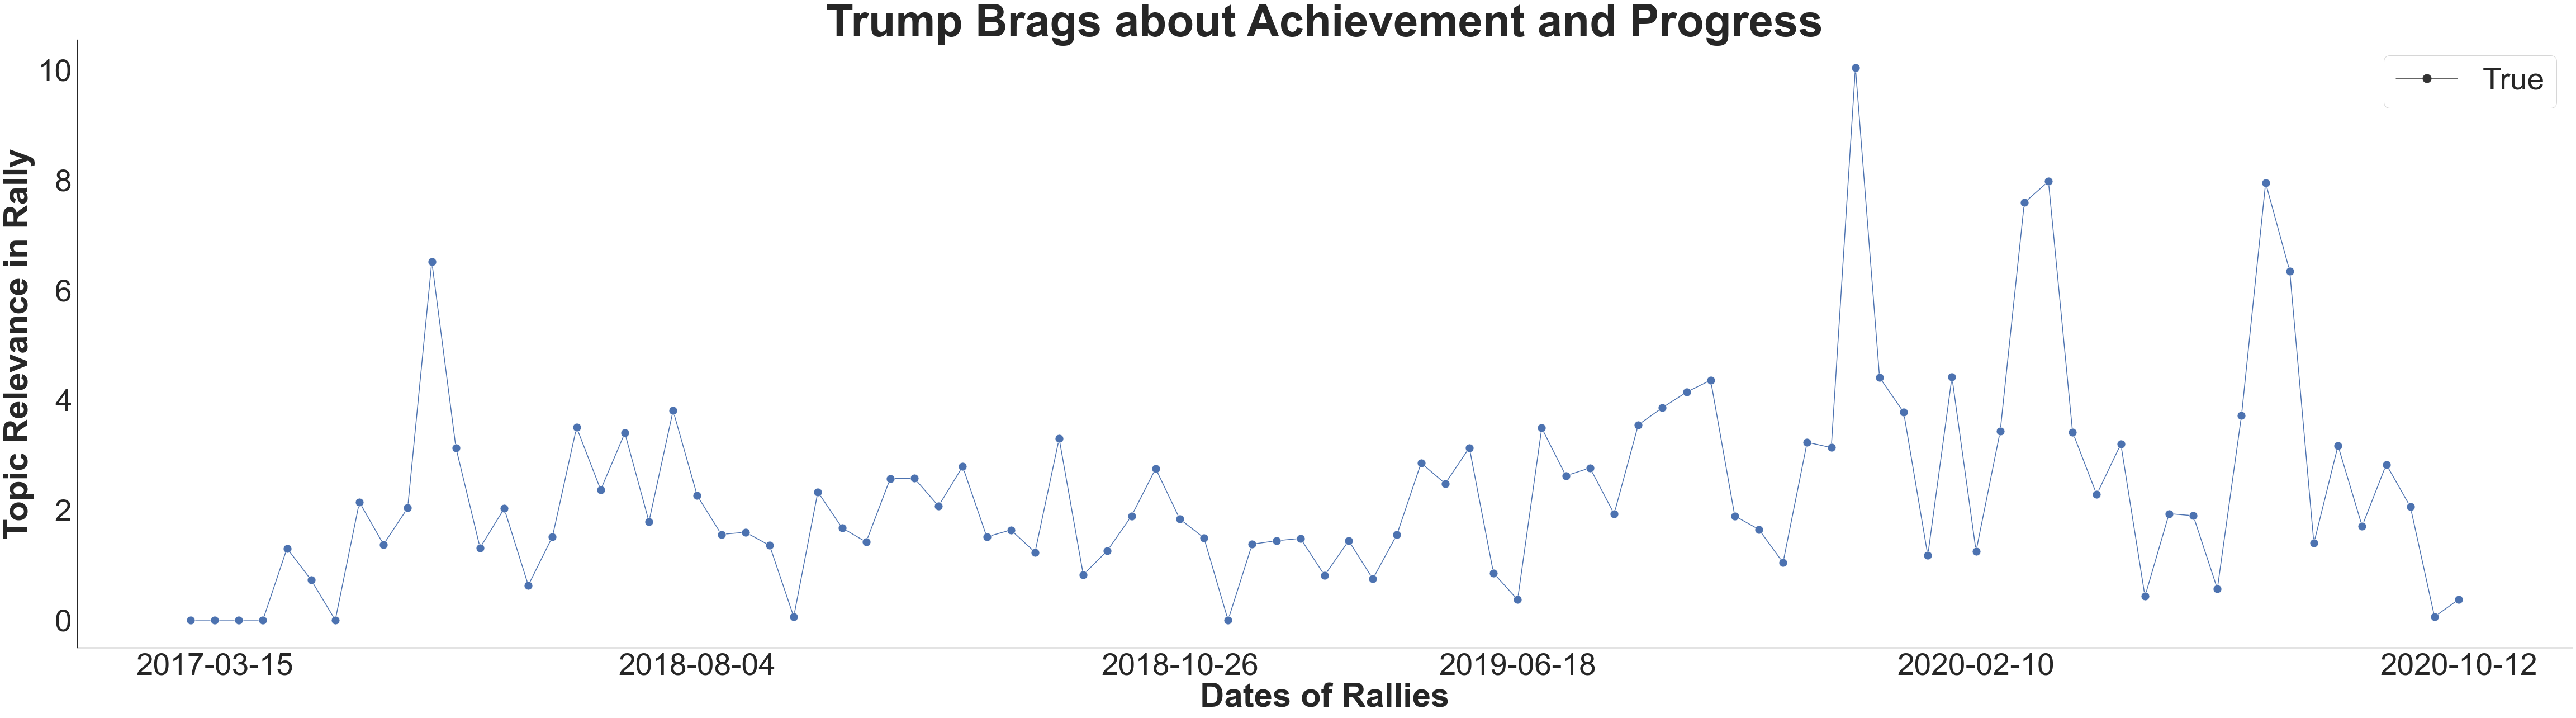

In [57]:
sns.set(style='white',font_scale=5,rc = {'lines.markersize': 15} )
fig = plt.figure(figsize=[80,20])
ax = sns.lineplot(x='Date',y='Achievements',data=H2,style=True,markers=True,ci=None)
plt.xticks(list(H2['Date'])[0::20])
#ymin, ymax = plt.ylim()
#plt.vlines(list(H2['Date'])[8::9], ymin, ymax, linestyle='dashed')
plt.ylabel('Achievements and Bragging')
plt.xlabel('Dates of Rallies',weight='bold',fontsize=60)
plt.ylabel('Topic Relevance in Rally',weight='bold',fontsize=60)
plt.title('Trump Brags about Achievement and Progress',weight='bold',fontsize=80)
sns.despine()
plt.savefig('SNSlineplot3_0.png',transparent=True, bbox_inches='tight')

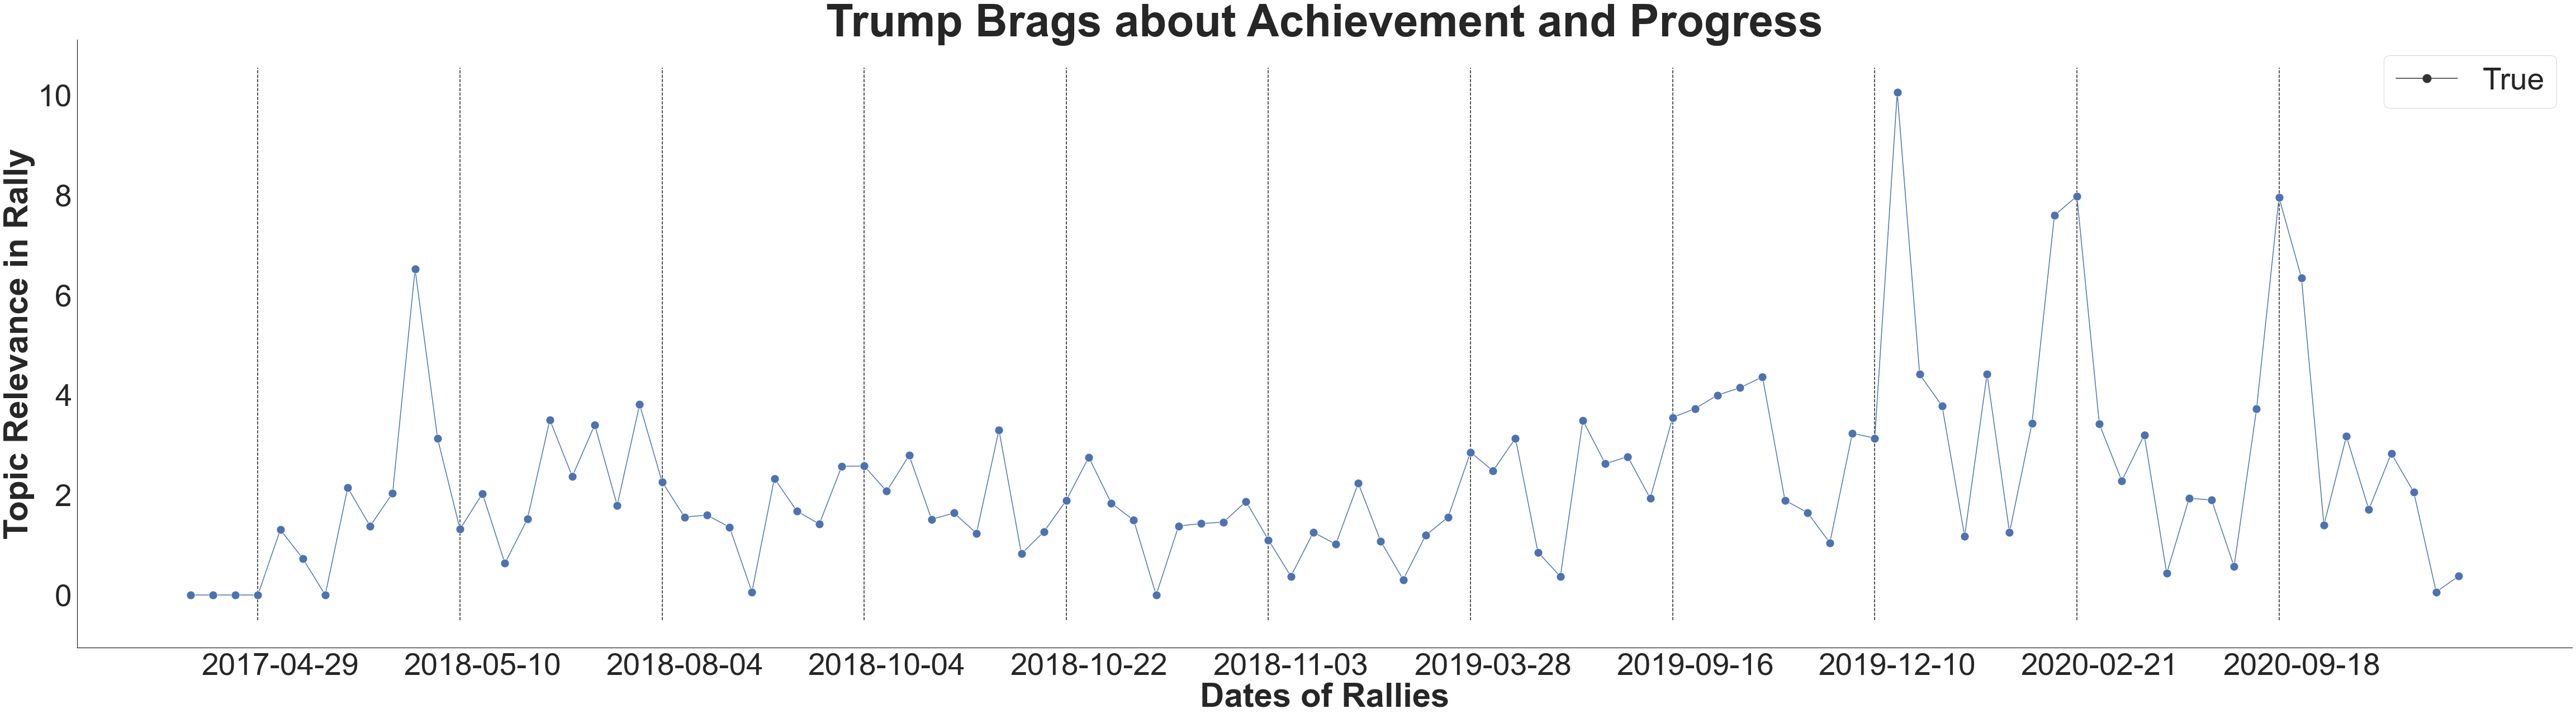

In [58]:
sns.set(style='white',font_scale=5,rc = {'lines.markersize': 15} )
fig = plt.figure(figsize=[80,20])
ax = sns.lineplot(x=H2.index[::-1],y=H2['Achievements'],style=True,markers=True,ci=None)
lst = ['']*102
lst[-9::-9] = list(H2['Date'][8::9])
plt.xticks(ticks=range(1,103),labels=lst)
ymin, ymax = plt.ylim()
plt.vlines(np.arange(3,102,9), ymin, ymax, linestyle='dashed')
plt.ylabel('Achievements and Bragging')
plt.xlabel('Dates of Rallies',weight='bold',fontsize=60)
plt.ylabel('Topic Relevance in Rally',weight='bold',fontsize=60)
plt.title('Trump Brags about Achievement and Progress',weight='bold',fontsize=80)
sns.despine()
plt.savefig('SNSlineplot3.png',transparent=True, bbox_inches='tight')

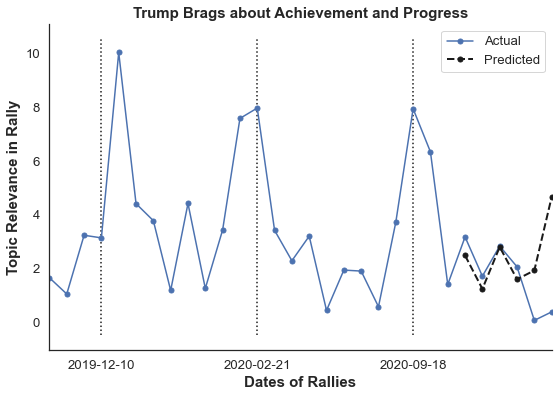

In [59]:
sns.set(style='white',font_scale=1.2,rc = {'lines.markersize': 15} )
fig = plt.figure(figsize=[9,6])
#sns.lineplot(x='Date',y='Political Adversaries',data=H2,style=True,markers=True,ci=None,color='r')
plt.plot(H3['Date'],H3['Achievements'],marker='.',markersize=10,linewidth=1.5,linestyle='-',color='b',label='Actual')
plt.plot(predicted2['Date'],predicted2['Achievements'],marker='.',markersize=10,linewidth=2,linestyle='--',color='k',label='Predicted')
plt.xticks(list(H2['Date'])[8::9])
ymin, ymax = plt.ylim()
plt.vlines(list(H2['Date'])[8::9], ymin, ymax, linestyle=':',)
plt.xlim(['2019-11-06','2020-10-12'])
plt.xlabel('Dates of Rallies',weight='bold',fontsize=15)
plt.ylabel('Topic Relevance in Rally',weight='bold',fontsize=15)
plt.title('Trump Brags about Achievement and Progress',weight='bold',fontsize=15)
plt.legend()
sns.despine()
plt.savefig('PLTlineplot3.png',transparent=True, bbox_inches='tight')

## Clustering of Trump Rallies
- K-means for Clustering
- Used Elbow method and Silhouette coefficients to determine optimum clusters
- Used 3D plot in Plotly to visualize clusters

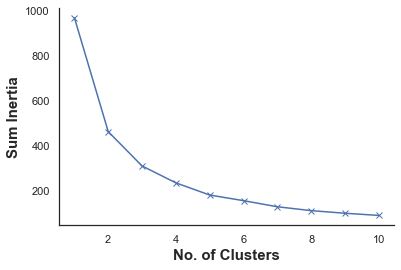

In [60]:
sns.set(style='white',font_scale=1)
inertia = []
for num_clusters in range(1,11):
    km = KMeans(n_clusters=num_clusters,random_state=71)
    km.fit(H[['Achievements','Plans and Appealing Support','Political Adversaries']])
    inertia.append(km.inertia_)
    
plt.plot(range(1,11),inertia,marker='x')
plt.ylabel('Sum Inertia',fontsize=15,weight='bold')
plt.xlabel('No. of Clusters',fontsize=15,weight='bold')
sns.despine()
plt.savefig('Elbow.png',transparent=True, bbox_inches='tight')

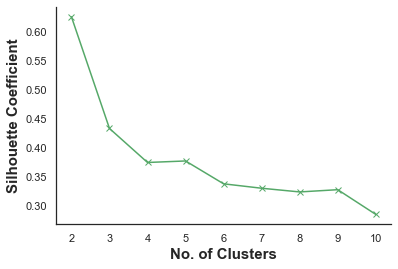

In [61]:
sns.set(style='white',font_scale=1)
silhouette = []
for num_clusters in range(2,11):
    km = KMeans(n_clusters=num_clusters,random_state=71)
    km.fit(H[['Achievements','Plans and Appealing Support','Political Adversaries']])
    labels = km.labels_
    silhouette.append(silhouette_score(H[['Achievements','Plans and Appealing Support','Political Adversaries']],labels=labels))
    
plt.plot(range(2,11),silhouette,marker='x',color='g')
plt.ylabel('Silhouette Coefficient',fontsize=15,weight='bold')
plt.xlabel('No. of Clusters',fontsize=15,weight='bold')
sns.despine()
plt.savefig('Silhouette.png',transparent=True, bbox_inches='tight')

In [62]:
km = KMeans(n_clusters=2,random_state=71)
km.fit(H[['Achievements','Plans and Appealing Support','Political Adversaries']])
labels = km.labels_
labels

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1])

In [63]:
labels = np.where(labels==0,'Trump Mainly Attacking','Trump Mainly Bragging')


In [64]:
data1 = []
clusters = []
colors = ['rgb(228,26,28)','rgb(55,126,184)'] # set our dot colors

for i in range(len(np.unique(labels))): # allows us to split our data into three distinct groups
    name = np.unique(labels)[i]
    color = colors[i]
    x = H[ labels == name ]['Achievements']
    y = H[ labels == name  ]['Plans and Appealing Support']
    z = H[ labels == name  ]['Political Adversaries']
    
    trace = dict(  # trace is how we "trace" or draw our data on the canvas
        name = name,
        x = x, y = y, z = z,
        type = "scatter3d",    
        mode = 'markers',
        marker = dict( size=2, color=color, line=dict(width=0) ) )
    data1.append( trace )

layout = dict( # we modify our canvas here, including initial layout and styles
    width=800,
    height=550,
    autosize=True,
    title='Trump Rally Topic Clusters',
    scene=dict(
        xaxis=dict(
            gridcolor='rgb(255, 255, 255)',
            zerolinecolor='rgb(255, 255, 255)',
            showbackground=True,
            backgroundcolor='rgb(230, 230,230)',
            title='Achievements and Bragging',  # set titles, very important
            titlefont=dict(
            family='Courier New',
            size=9,
            color='#2f2f2f'),  # we can use hex, rgba, or other color variants
        ),
        yaxis=dict(
            gridcolor='rgb(255, 255, 255)',
            zerolinecolor='rgb(255, 255, 255)',
            showbackground=True,
            backgroundcolor='rgb(230, 230,230)',
            title='Plans and Appealing Support',  # set titles, very important
            titlefont=dict(
            family='Courier New',
            size=9,
            color='#4f4f4f'),
        ),
        zaxis=dict(
            gridcolor='rgb(255, 255, 255)',
            zerolinecolor='rgb(255, 255, 255)',
            showbackground=True,
            backgroundcolor='rgb(230, 230,230)',
            title='Political Adversaries',  # set titles, very important
            titlefont=dict(
            family='Courier New',
            size=9,
            color='#7f7f7f'),
        ),
        aspectratio = dict( x=1, y=1, z=1 ), # we can compress large dimensions this way
        aspectmode = 'manual'        
    ),
)

fig = dict(data=data1, layout=layout) # this finally compiles our figure

# run locally in notebook
iplot(fig)

### Further Evaluate Time Series Model on More Test Set (Newer Trump Rallies)

In [65]:
df_test = pd.read_csv('Trump_Rallies_Test_Set.csv',parse_dates=['Date'])
df_test = df_test.drop('Unnamed: 0',axis=1)
df_test['Place'] = df_test['Place'].apply(lambda x: re.sub(r'^.*(?=Rally)','',x))
df_test['Transcript'] = df_test['Transcript'].apply(lambda x: re.sub(r'\[.*?\]','',x))
df_test['Transcript'] = df_test['Transcript'].apply(lambda x: x.lower())
df_test['Transcript'] = df_test['Transcript'].apply(lambda x: tokenizer.tokenize(x))
df_test['Transcript'] = df_test['Transcript'].apply(lambda x: ' '.join(x))
df_test['Transcript'] = df_test['Transcript'].apply(lambda x: remove_stopwords(x))


In [66]:
count_vectorizer = CountVectorizer(stop_words = 'english')
doc_term1 = countvec.transform(list(df_test['Transcript']))

In [67]:
doc_topic1 = model.transform(doc_term1)

In [68]:
H_test = pd.DataFrame(doc_topic1.round(3),
             index = [i for i in df_test['Place']],
             columns = ["component_1","component_2","component_3"])
H_test

component_1  component_2  component_3
Rally in Macon, Georgia                     4.751        1.805        6.748
Rally in Greenville, North Carolina         4.402        1.021        3.724
Rally in Des Moines, Iowa                   3.231        1.337        6.154
Rally in Johnstown, Pennsylvania            1.658        0.950        6.236

In [69]:
H_test = H_test.reset_index()
H_test = df_test.join(H_test).drop(['Transcript','index'],axis=1)
H_test = H_test.rename(columns={'component_1':'Achievements','component_2':'Plans and Appealing Support','component_3':'Political Adversaries'})
H_test

Place       Date  Achievements  \
0              Rally in Macon, Georgia  2020-10-16         4.751   
1  Rally in Greenville, North Carolina  2020-10-15         4.402   
2            Rally in Des Moines, Iowa  2020-10-14         3.231   
3     Rally in Johnstown, Pennsylvania  2020-10-13         1.658   

   Plans and Appealing Support  Political Adversaries  
0                        1.805                  6.748  
1                        1.021                  3.724  
2                        1.337                  6.154  
3                        0.950                  6.236

In [70]:
data_test = H_test.drop(['Place','Date'],axis=1)
data_test.index = H_test['Date']
data_test = data_test.iloc[::-1]
data_test

Achievements  Plans and Appealing Support  Political Adversaries
Date                                                                        
2020-10-13         1.658                        0.950                  6.236
2020-10-14         3.231                        1.337                  6.154
2020-10-15         4.402                        1.021                  3.724
2020-10-16         4.751                        1.805                  6.748

In [71]:
data_Achievements = data['Achievements']
data_Support = data['Plans and Appealing Support']
data_Adversaries = data['Political Adversaries']
data_test_Achievements = data_test['Achievements']
data_test_Support = data_test['Plans and Appealing Support']
data_test_Adversaries = data_test['Political Adversaries']

In [72]:
forecast_Adversaries = SARIMAX(data_Adversaries,order=(1,0,0),seasonal_order=(1,1,1,10),trend='ct').fit().forecast(steps=len(data_test_Adversaries))
MAE_Adversaries = mean_absolute_error(data_test['Political Adversaries'],forecast_Adversaries)
print(f'MAE_Adversaries: {MAE_Adversaries}')
    
forecast_Support = SARIMAX(data_Support,order=(1,0,0),seasonal_order=(1,1,1,8),trend='ct').fit().forecast(steps=len(data_test_Support))
MAE_Support = mean_absolute_error(data_test['Plans and Appealing Support'],forecast_Support) 
print(f'MAE_Support: {MAE_Support}')
    
forecast_Achievements = SARIMAX(data_Achievements,order=(1,0,0),seasonal_order=(1,1,1,9),trend='n').fit().forecast(steps=len(data_test_Achievements))
MAE_Achievements = mean_absolute_error(data_test['Achievements'],forecast_Achievements)  
print(f'MAE_Achievements: {MAE_Achievements}')

MAE_Adversaries: 1.080880180477907
MAE_Support: 0.7973618404804071
MAE_Achievements: 1.9288391359430928


In [73]:
predicted = data_test.copy()
predicted['Achievements'] = list(forecast_Achievements)
predicted['Plans and Appealing Support'] = list(forecast_Support)
predicted['Political Adversaries'] = list(forecast_Adversaries)
predicted2 = predicted.copy()
predicted2 = predicted2.reset_index()
predicted2['Date'] = predicted2['Date'].astype(str)

In [74]:
H_test = pd.concat([H_test,H],axis=0)
H_test

Place       Date  Achievements  \
0                     Rally in Macon, Georgia  2020-10-16         4.751   
1         Rally in Greenville, North Carolina  2020-10-15         4.402   
2                   Rally in Des Moines, Iowa  2020-10-14         3.231   
3            Rally in Johnstown, Pennsylvania  2020-10-13         1.658   
0                    Rally in Sanford, Florida 2020-10-12         0.376   
1                   Rally in Duluth, Minnesota 2020-09-30         0.060   
2            Rally in Middletown, Pennsylvania 2020-09-26         2.058   
3              Rally in Newport News, Virginia 2020-09-25         2.830   
4               Rally in Jacksonville, Florida 2020-09-24         1.708   
5         Rally in Moon Township, Pennsylvania 2020-09-22         3.171   
6                       Rally in Swanton, Ohio 2020-09-21         1.398   
7        Rally in Fayetteville, North Carolina 2020-09-19         6.343   
8                 Rally in Bedmidji, Minnesota 2020-09-18         7.949   
9                  Rally in Mosinee, Wisconsin 2020-09-17         3.718   
10                  Rally in Henderson, Nevada 2020-09-13         0.569   
11                     Rally in Minden, Nevada 2020-09-12         1.898   
12                 Rally in Freeland, Michigan 2020-09-10         1.935   
13      Rally in Winston-Salem, North Carolina 2020-09-08         0.431   
14                    Rally in Tulsa, Oklahoma 2020-06-20         3.201   
15          Rally in Charlotte, North Carolina 2020-03-02         2.283   
16   Rally in North Charleston, South Carolina 2020-02-28         3.417   
17                  Rally in Las Vegas, Nevada 2020-02-21         7.975   
18         Rally in Colorado Springs, Colorado 2020-02-20         7.589   
19                   Rally in Phoenix, Arizona 2020-02-19         3.431   
20          Rally in Manchester, New Hampshire 2020-02-10         1.252   
21                   Rally in Des Moines, Iowa 2020-01-30         4.418   
22               Rally in Wildwood, New Jersey 2020-01-28         1.176   
23               Rally in Milwaukee, Wisconsin 2020-01-14         3.777   
24                       Rally in Toledo, Ohio 2020-01-09         4.412   
25             Rally in Battle Creek, Michigan 2019-12-18        10.048   
26              Rally in Hershey, Pennsylvania 2019-12-10         3.136   
27                   Rally in Sunrise, Florida 2019-11-26         3.233   
28            Rally in Bossier City, Louisiana 2019-11-14         1.044   
29                  Rally in Monroe, Louisiana 2019-11-06         1.648   
30                Rally in Lexington, Kentucky 2019-11-04         1.893   
31                Rally in Tupelo, Mississippi 2019-11-01         4.362   
32                      Rally in Dallas, Texas 2019-10-17         4.143   
33             Rally in Minneapolis, Minnesota 2019-10-10         3.997   
34            Rally in Lake Charles, Louisiana 2019-10-10         3.727   
35             Rally in Rio Rancho, New Mexico 2019-09-16         3.549   
36       Rally in Fayetteville, North Carolina 2019-09-09         1.931   
37          Rally in Manchester, New Hampshire 2019-08-15         2.766   
38                   Rally in Cincinnati, Ohio 2019-08-01         2.624   
39         Rally in Greenville, North Carolina 2019-07-17         3.492   
40                            Rally in Orlando 2019-06-18         0.371   
41        Rally in Montoursville, Pennsylvania 2019-05-20         0.855   
42         Rally in Panama City Beach, Florida 2019-05-08         3.135   
43               Rally in Green Bay, Wisconsin 2019-04-27         2.481   
44             Rally in Grand Rapids, Michigan 2019-03-28         2.856   
45                     Rally in El Paso, Texas 2019-02-11         1.556   
46                Rally in Tupelo, Mississippi 2018-11-26         1.191   
47                Rally in Biloxi, Mississippi 2018-11-26         0.306   
48                Rally in Fort Wayne, Indiana 2018-11-05         

In [75]:
H2 = H_test.copy()
H2['Date'] = H2['Date'].astype(str)
H3 = H2.copy()
H3 = H3.iloc[::-1]

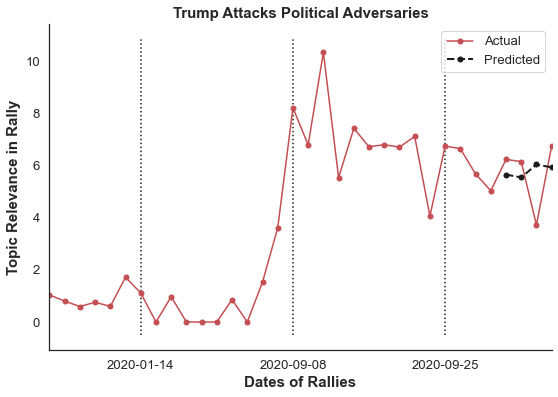

In [76]:
sns.set(style='white',font_scale=1.2,rc = {'lines.markersize': 15} )
fig = plt.figure(figsize=[9,6])
#sns.lineplot(x='Date',y='Political Adversaries',data=H2,style=True,markers=True,ci=None,color='r')
plt.plot(H3['Date'],H3['Political Adversaries'],marker='.',markersize=10,linewidth=1.5,linestyle='-',color='r',label='Actual')
plt.plot(predicted2['Date'],predicted2['Political Adversaries'],marker='.',markersize=10,linewidth=2,linestyle='--',color='k',label='Predicted')
plt.xticks(list(H2['Date'])[7::10])
ymin, ymax = plt.ylim()
plt.vlines(list(H2['Date'])[7::10], ymin, ymax, linestyle=':')
plt.xlim(['2019-11-06','2020-10-16'])
plt.xlabel('Dates of Rallies',weight='bold',fontsize=15)
plt.ylabel('Topic Relevance in Rally',weight='bold',fontsize=15)
plt.title('Trump Attacks Political Adversaries',weight='bold',fontsize=15)
plt.legend()
sns.despine()
plt.savefig('PLTlineplot4.png',transparent=True, bbox_inches='tight')

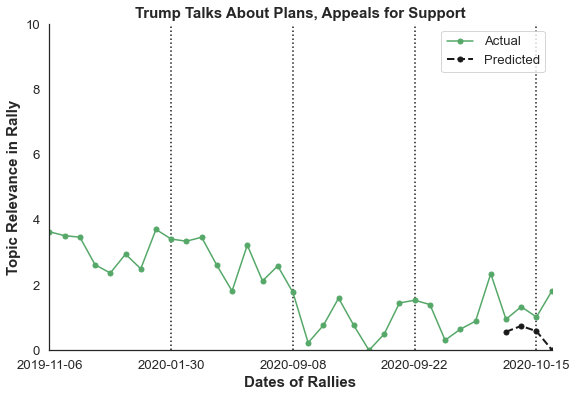

In [77]:
sns.set(style='white',font_scale=1.2,rc = {'lines.markersize': 15} )
fig = plt.figure(figsize=[9,6])
#sns.lineplot(x='Date',y='Political Adversaries',data=H2,style=True,markers=True,ci=None,color='r')
plt.plot(H3['Date'],H3['Plans and Appealing Support'],marker='.',markersize=10,linewidth=1.5,linestyle='-',color='g',label='Actual')
plt.plot(predicted2['Date'],predicted2['Plans and Appealing Support'],marker='.',markersize=10,linewidth=2,linestyle='--',color='k',label='Predicted')
plt.xticks(list(H2['Date'])[1::8])
plt.ylim([0,10])
ymin, ymax = plt.ylim()
plt.vlines(list(H2['Date'])[1::8], ymin, ymax, linestyle=':')
plt.xlim(['2019-11-06','2020-10-16'])
plt.yticks([0,2,4,6,8,10])
plt.xlabel('Dates of Rallies',weight='bold',fontsize=15)
plt.ylabel('Topic Relevance in Rally',weight='bold',fontsize=15)
plt.title('Trump Talks About Plans, Appeals for Support',weight='bold',fontsize=15)
plt.legend()
sns.despine()
plt.savefig('PLTlineplot5.png',transparent=True, bbox_inches='tight')

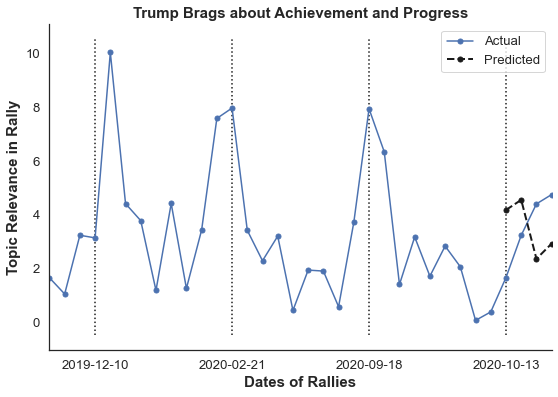

In [78]:
sns.set(style='white',font_scale=1.2,rc = {'lines.markersize': 15} )
fig = plt.figure(figsize=[9,6])
#sns.lineplot(x='Date',y='Political Adversaries',data=H2,style=True,markers=True,ci=None,color='r')
plt.plot(H3['Date'],H3['Achievements'],marker='.',markersize=10,linewidth=1.5,linestyle='-',color='b',label='Actual')
plt.plot(predicted2['Date'],predicted2['Achievements'],marker='.',markersize=10,linewidth=2,linestyle='--',color='k',label='Predicted')
plt.xticks(list(H2['Date'])[3::9])
ymin, ymax = plt.ylim()
plt.vlines(list(H2['Date'])[3::9], ymin, ymax, linestyle=':',)
plt.xlim(['2019-11-06','2020-10-16'])
plt.xlabel('Dates of Rallies',weight='bold',fontsize=15)
plt.ylabel('Topic Relevance in Rally',weight='bold',fontsize=15)
plt.title('Trump Brags about Achievement and Progress',weight='bold',fontsize=15)
plt.legend()
sns.despine()
plt.savefig('PLTlineplot6.png',transparent=True, bbox_inches='tight')